# DAA Based Up and Down-regulation in Subtypes

In [ ]:
import os
os.chdir('../')

Loading data...
CD data shape: (155, 3296)
UC data shape: (96, 3296)
Number of CD metabolic features: 3293
Number of UC metabolic features: 3293
Number of common metabolic features: 3293

Differential Abundance Analysis Between CD Clusters


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)



Differentially abundant metabolites (|FC| > 1.5, FDR < 0.05):
Up-regulated in Cluster 1: 1786
Down-regulated in Cluster 1: 394
Not significant: 1113


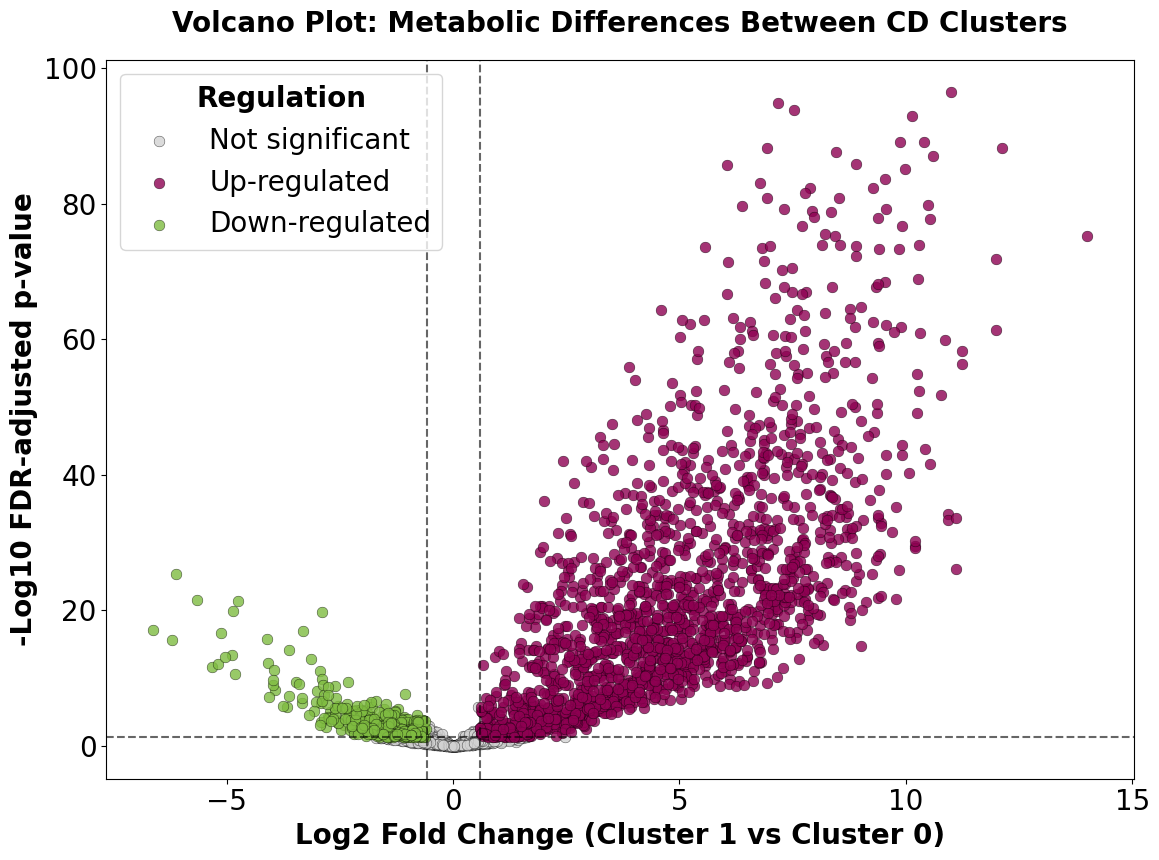


Results saved to:
- data/CD_differential_metabolites.tsv (all results)
- data/CD_up_regulated_metabolites.tsv (up in Cluster 1)
- data/CD_down_regulated_metabolites.tsv (down in Cluster 1)
- data/CD_differential_metabolites_volcano.png (volcano plot)

Generating heatmap of top differential metabolites...


<Figure size 1600x1200 with 0 Axes>

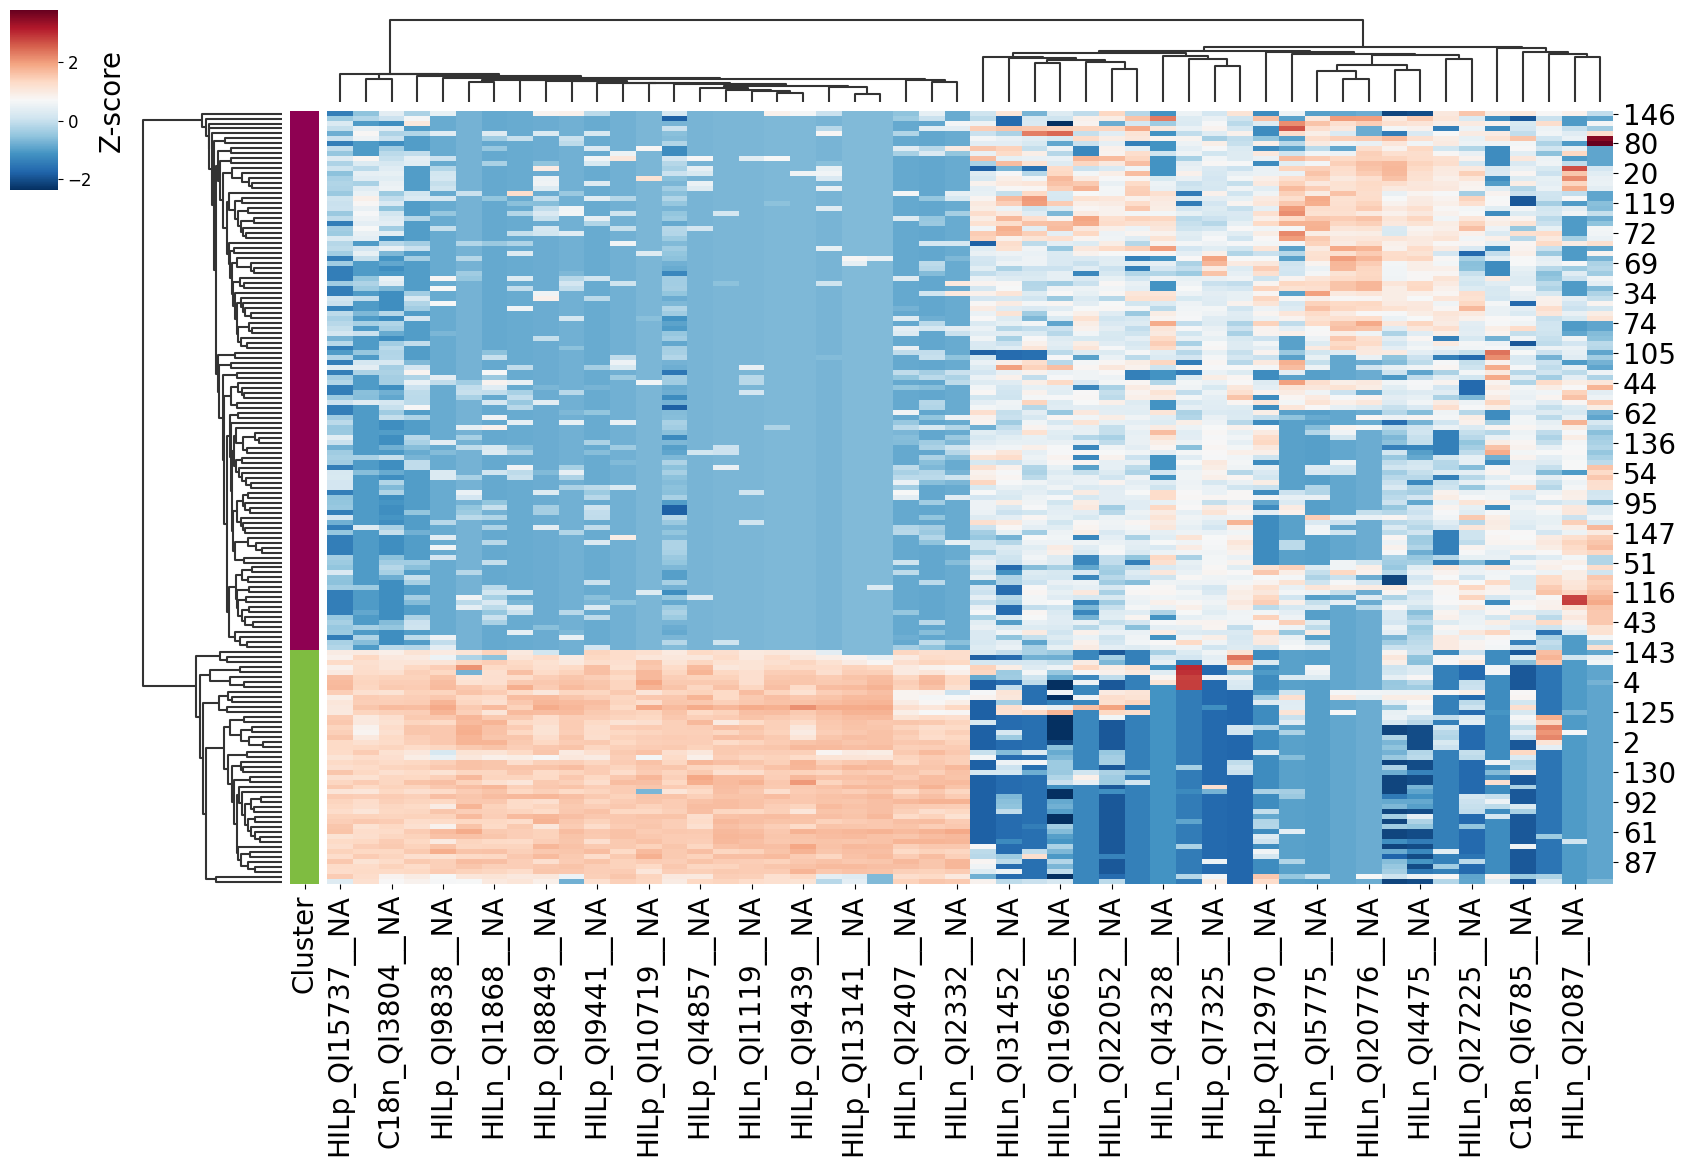

Heatmap saved to: data/CD_differential_metabolites_heatmap.png

Differential Abundance Analysis Between UC Clusters


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)



Differentially abundant metabolites (|FC| > 1.5, FDR < 0.05):
Up-regulated in Cluster 1: 151
Down-regulated in Cluster 1: 1887
Not significant: 1255


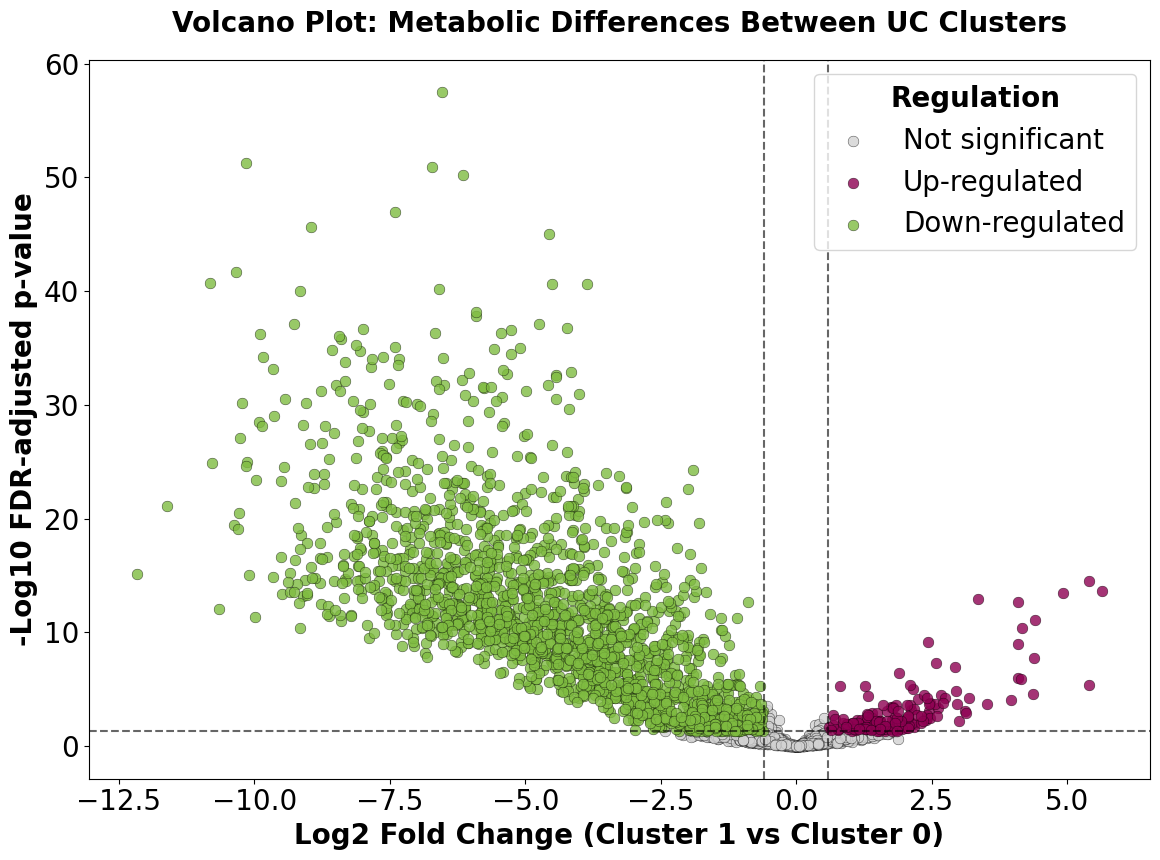


Results saved to:
- data/UC_differential_metabolites.tsv (all results)
- data/UC_up_regulated_metabolites.tsv (up in Cluster 1)
- data/UC_down_regulated_metabolites.tsv (down in Cluster 1)
- data/UC_differential_metabolites_volcano.png (volcano plot)

Generating heatmap of top differential metabolites...


<Figure size 1600x1200 with 0 Axes>

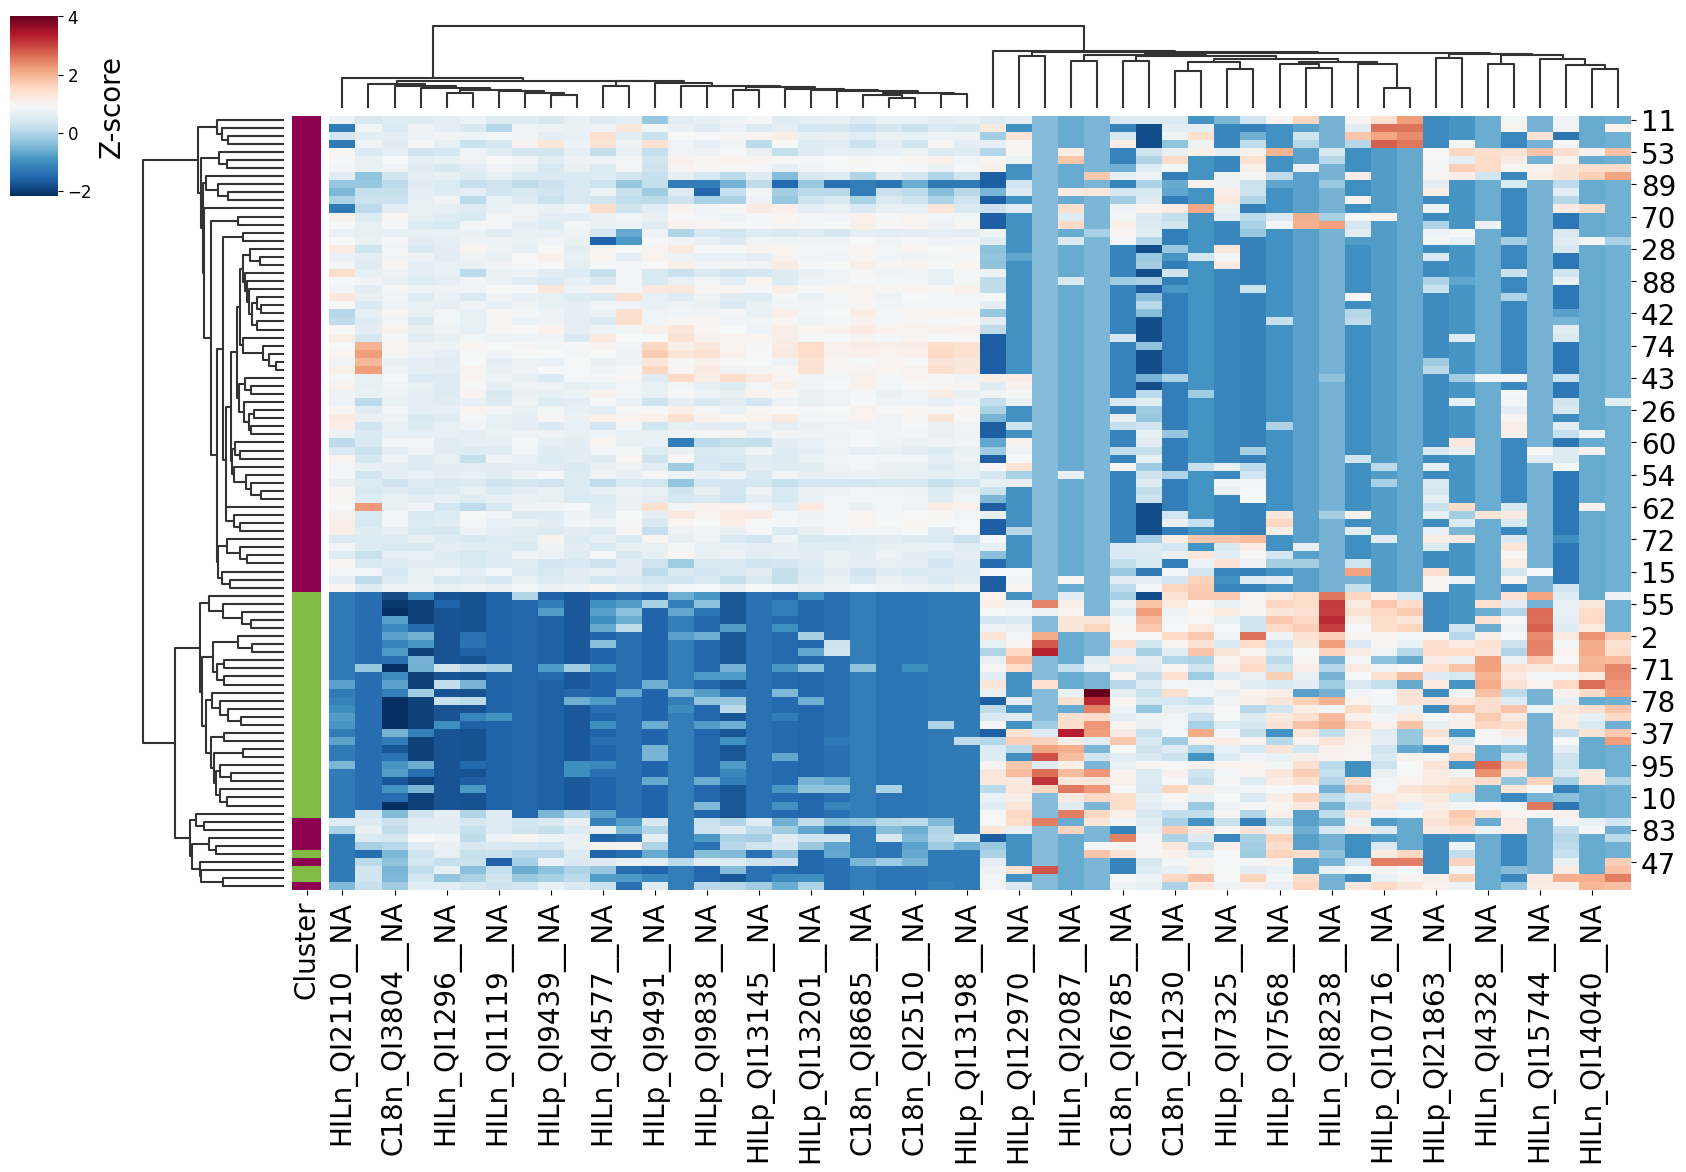

Heatmap saved to: data/UC_differential_metabolites_heatmap.png

Comparison of CD and UC Differential Metabolites
CD significant metabolites: 2180
UC significant metabolites: 2038
Overlapping significant metabolites: 1811
Percentage of CD metabolites also significant in UC: 83.1%
Percentage of UC metabolites also significant in CD: 88.9%

Directional consistency in overlapping metabolites:
Same direction in both diseases: 6 (0.3%)
Opposite direction between diseases: 1805 (99.7%)


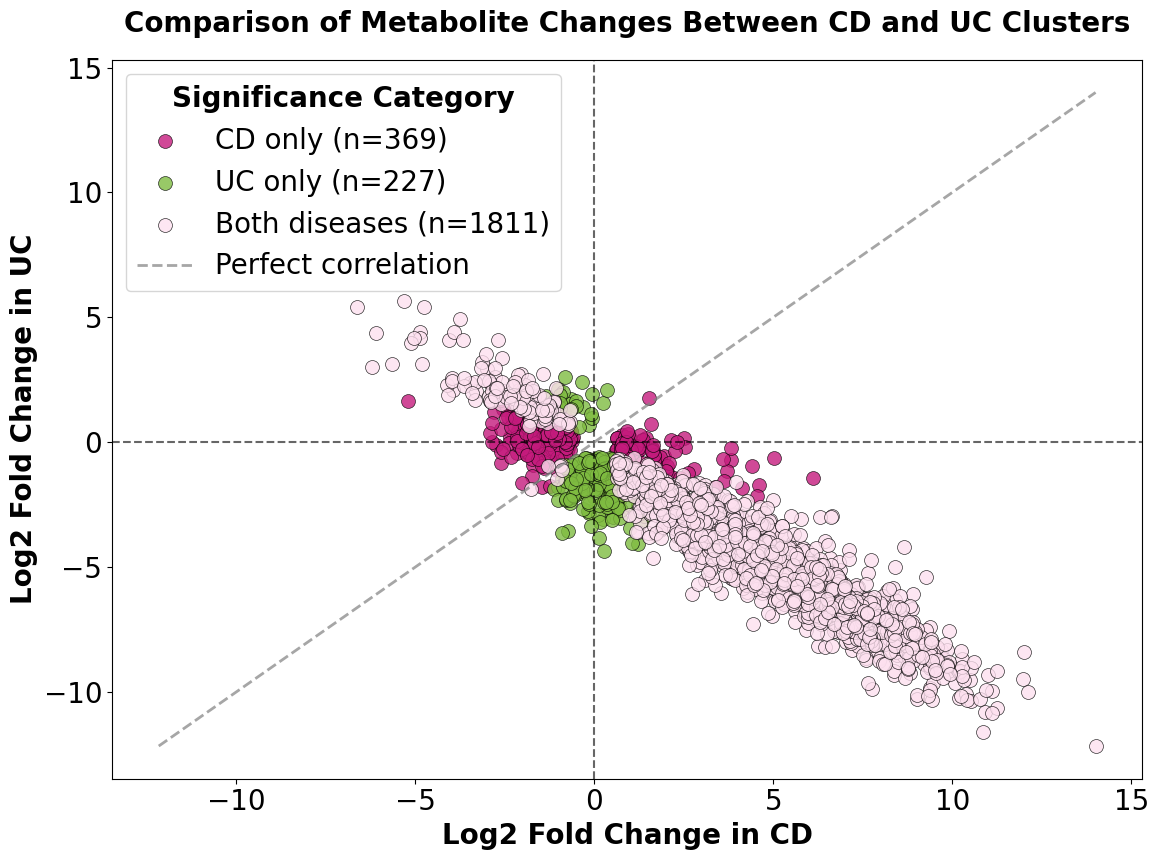


Comparison plot saved to: data/CD_UC_metabolite_comparison.png
Plot includes 369 CD-only, 227 UC-only, and 1811 shared significant metabolites
Comparison data saved to: data/CD_UC_differential_metabolite_comparison.tsv

Detailed Analysis of Shared Metabolites (Significant in Both Diseases)


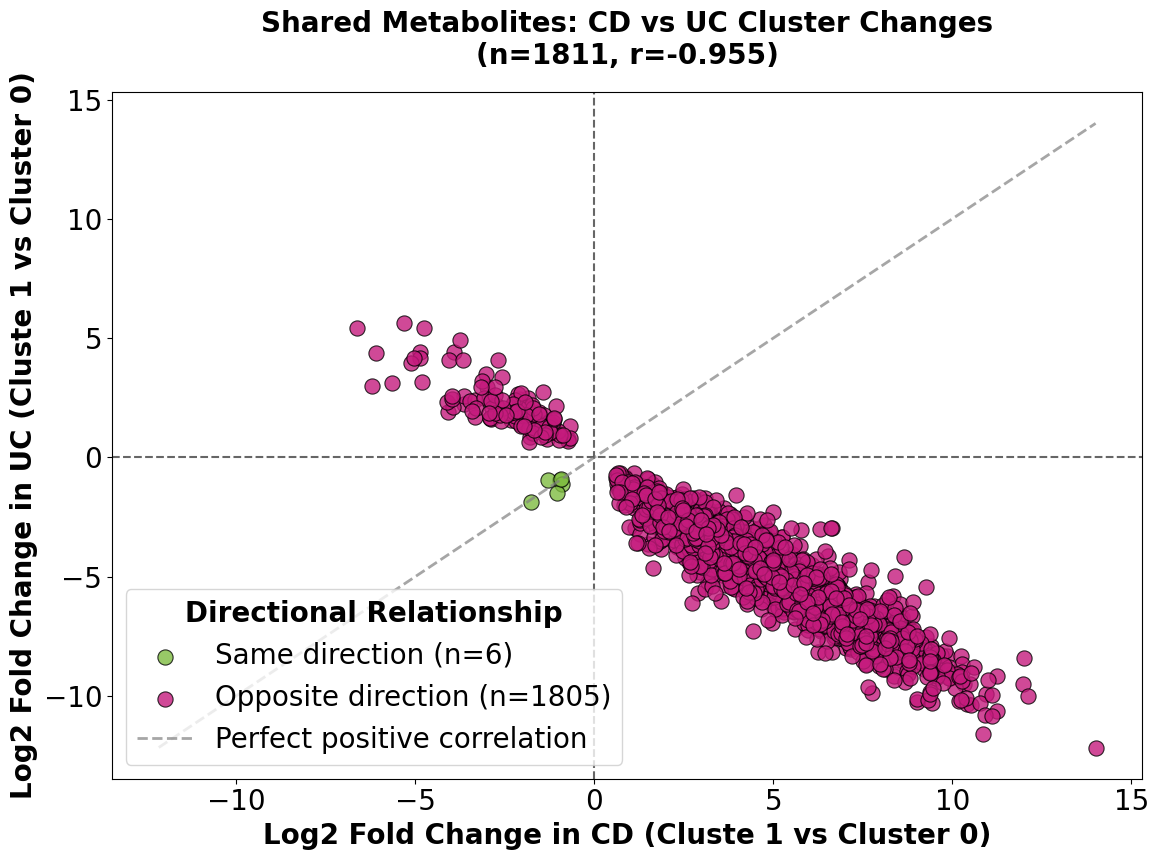


Shared metabolites detailed plot saved to: data/CD_UC_shared_metabolites_detailed.png
Correlation between CD and UC fold changes: r = -0.955
Metabolites with same direction: 6/1811 (0.3%)
Metabolites with opposite direction: 1805/1811 (99.7%)
Shared metabolites comparison data saved to: data/CD_UC_shared_metabolites_comparison.tsv


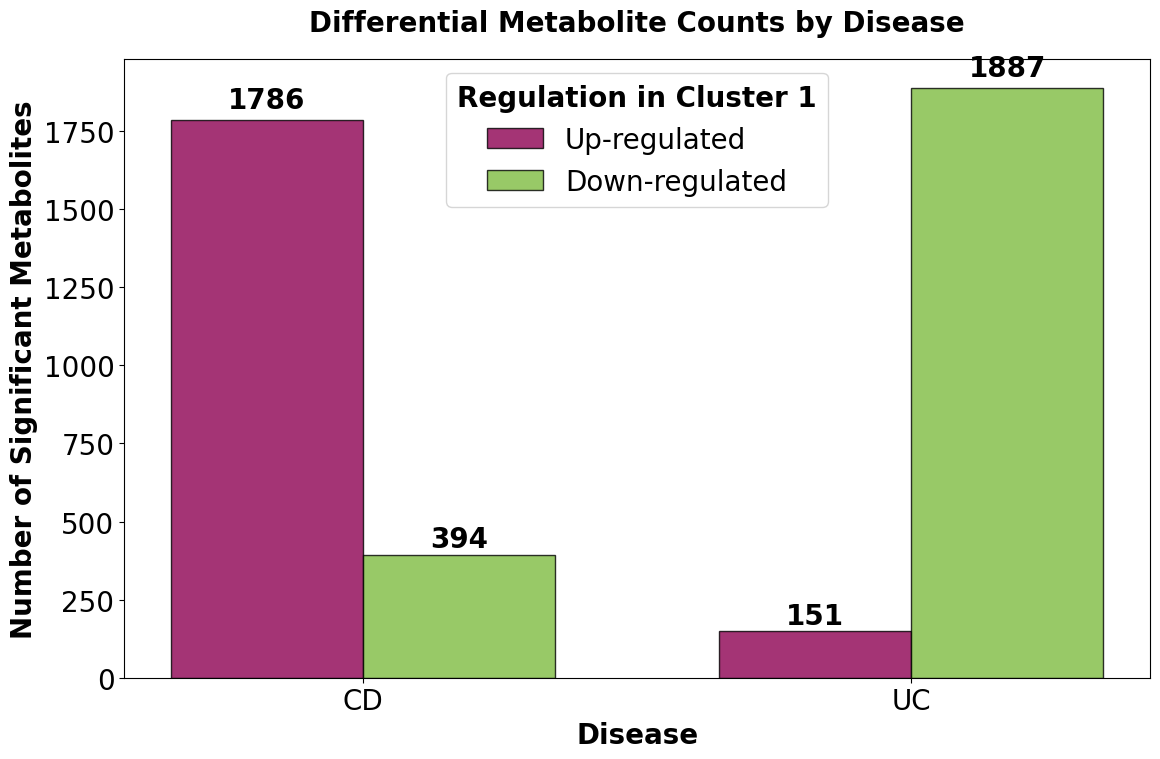


Disease-Specific Metabolites Visualization (Excluding Shared)
CD-specific significant metabolites: 369
UC-specific significant metabolites: 227


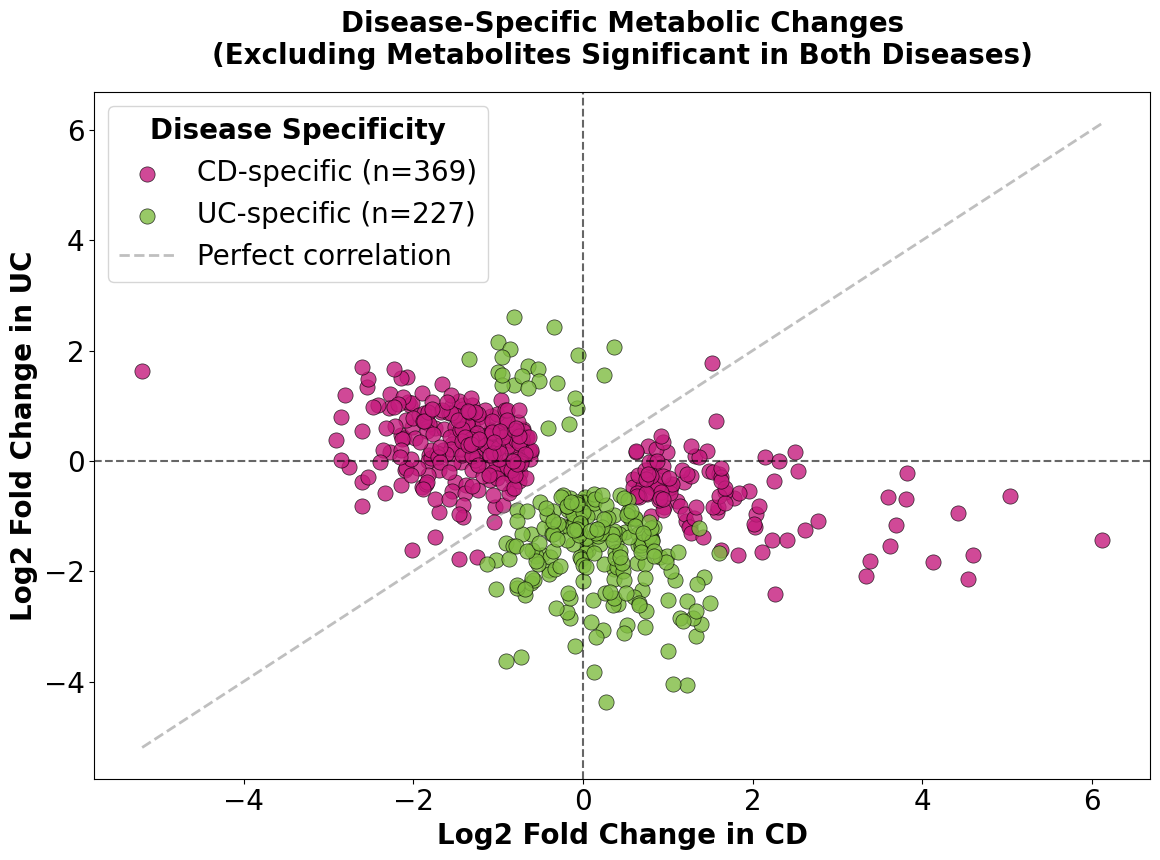

Disease-specific comparison data saved to: data/CD_UC_disease_specific_comparison.tsv

Disease Specificity Summary:
Disease  Specific_Metabolites  Total_Significant  Percentage_Specific
     CD                   369               2180                 16.9
     UC                   227               2038                 11.1
Specificity summary saved to: data/disease_specificity_summary.tsv


In [ ]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings('ignore')


colors = ['#8e0152','#c51b7d','#de77ae','#f1b6da','#fde0ef','#e6f5d0','#b8e186','#7fbc41','#4d9221','#276419']

# Set global font sizes
plt.rcParams.update({
    'font.size': 20,
    'axes.titlesize': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'legend.fontsize': 20,
    'figure.titlesize': 20
})

print("Loading data...")
cd_clustered_file = 'processing_data/cd_clusters/cd_clustered_df_k2.tsv'
uc_clustered_file = 'processing_data/uc_clusters/uc_clustered_df_k2.tsv'

cd_df = pd.read_csv(cd_clustered_file, sep='\t')
uc_df = pd.read_csv(uc_clustered_file, sep='\t')

print(f"CD data shape: {cd_df.shape}")
print(f"UC data shape: {uc_df.shape}")

# Identify feature columns separately for each disease
cd_feature_cols = [col for col in cd_df.columns if col.startswith(('C18n_', 'C8p_', 'HILn_', 'HILp_'))]
uc_feature_cols = [col for col in uc_df.columns if col.startswith(('C18n_', 'C8p_', 'HILn_', 'HILp_'))]

print(f"Number of CD metabolic features: {len(cd_feature_cols)}")
print(f"Number of UC metabolic features: {len(uc_feature_cols)}")

# Find common features between datasets
common_features = set(cd_feature_cols).intersection(set(uc_feature_cols))
print(f"Number of common metabolic features: {len(common_features)}")

# Extract cluster labels
cluster_labels_cd = cd_df['KMeans_Cluster_CD_K2'].values
cluster_labels_uc = uc_df['KMeans_Cluster_UC_K2'].values

# Function to perform differential abundance analysis
def differential_abundance_analysis(df, cluster_labels, feature_cols, disease_name):
    print("\n" + "="*50)
    print(f"Differential Abundance Analysis Between {disease_name} Clusters")
    print("="*50)
    
    # 1. Calculate statistics for each metabolite
    results = []
    for feature in feature_cols:
        # Get values for each cluster
        values_cluster0 = df.loc[cluster_labels == 0, feature]
        values_cluster1 = df.loc[cluster_labels == 1, feature]
        
        # Calculate fold change (data is already log-transformed)
        mean_cluster0 = values_cluster0.mean()
        mean_cluster1 = values_cluster1.mean()
        log2_fold_change = mean_cluster1 - mean_cluster0
        
        # Perform t-test
        t_stat, p_val = stats.ttest_ind(values_cluster1, values_cluster0, equal_var=False)
        
        results.append({
            'feature': feature,
            'mean_cluster0': mean_cluster0,
            'mean_cluster1': mean_cluster1,
            'log2_fold_change': log2_fold_change,
            't_statistic': t_stat,
            'p_value': p_val
        })
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    # 2. Apply FDR correction
    results_df['fdr_adjusted_p'] = multipletests(results_df['p_value'], method='fdr_bh')[1]
    
    # 3. Applying thresholds to identify significant metabolites
    # Using |log2_fold_change| > log2(1.5) and FDR < 0.05
    log2_fc_threshold = np.log2(1.5)
    fdr_threshold = 0.05
    
    results_df['significant'] = (abs(results_df['log2_fold_change']) > log2_fc_threshold) & (results_df['fdr_adjusted_p'] < fdr_threshold)
    results_df['regulation'] = 'NS'  # Not significant
    results_df.loc[(results_df['significant']) & (results_df['log2_fold_change'] > 0), 'regulation'] = 'Up'
    results_df.loc[(results_df['significant']) & (results_df['log2_fold_change'] < 0), 'regulation'] = 'Down'
    
    # Count significant metabolites
    sig_counts = results_df['regulation'].value_counts()
    print(f"\nDifferentially abundant metabolites (|FC| > 1.5, FDR < 0.05):")
    print(f"Up-regulated in Cluster 1: {sig_counts.get('Up', 0)}")
    print(f"Down-regulated in Cluster 1: {sig_counts.get('Down', 0)}")
    print(f"Not significant: {sig_counts.get('NS', 0)}")
    
    # 4. Create a volcano plot with custom styling
    plt.figure(figsize=(12, 9))
    
    # Create separate scatter plots for each regulation type with custom colors
    for reg_type, color in [('NS', 'lightgray'), ('Up', colors[0]), ('Down', colors[7])]:
        mask = results_df['regulation'] == reg_type
        if mask.any():
            plt.scatter(
                results_df.loc[mask, 'log2_fold_change'],
                -np.log10(results_df.loc[mask, 'fdr_adjusted_p']),
                c=color,
                label=f'{reg_type}-regulated' if reg_type != 'NS' else 'Not significant',
                alpha=0.8,
                s=60,
                edgecolors='black',
                linewidth=0.3
            )
    plt.axhline(-np.log10(fdr_threshold), color='black', linestyle='--', alpha=0.6, linewidth=1.5)
    plt.axvline(log2_fc_threshold, color='black', linestyle='--', alpha=0.6, linewidth=1.5)
    plt.axvline(-log2_fc_threshold, color='black', linestyle='--', alpha=0.6, linewidth=1.5)
    plt.title(f'Volcano Plot: Metabolic Differences Between {disease_name} Clusters', 
              fontsize=20, fontweight='bold', pad=20)
    plt.xlabel('Log2 Fold Change (Cluster 1 vs Cluster 0)', 
               fontsize=20, fontweight='bold')
    plt.ylabel('-Log10 FDR-adjusted p-value', 
               fontsize=20, fontweight='bold')
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    legend = plt.legend(fontsize=20, title_fontsize=20)
    legend.set_title("Regulation", prop={'size': 20, 'weight': 'semibold'})
    plt.grid(False)
    plt.tight_layout()
    plt.show()
    
    # 5. Save the results
    results_df.to_csv(f'data/{disease_name}_differential_metabolites.tsv', sep='\t', index=False)
    
    # 6. Export lists of significant metabolites
    up_regulated = results_df[results_df['regulation'] == 'Up'].sort_values('log2_fold_change', ascending=False)
    down_regulated = results_df[results_df['regulation'] == 'Down'].sort_values('log2_fold_change')
    
    up_regulated.to_csv(f'data/{disease_name}_up_regulated_metabolites.tsv', sep='\t', index=False)
    down_regulated.to_csv(f'data/{disease_name}_down_regulated_metabolites.tsv', sep='\t', index=False)
    
    print(f"\nResults saved to:")
    print(f"- data/{disease_name}_differential_metabolites.tsv (all results)")
    print(f"- data/{disease_name}_up_regulated_metabolites.tsv (up in Cluster 1)")
    print(f"- data/{disease_name}_down_regulated_metabolites.tsv (down in Cluster 1)")
    print(f"- data/{disease_name}_differential_metabolites_volcano.png (volcano plot)")
    
    # 7. Create a heatmap of top differentially abundant metabolites
    print("\nGenerating heatmap of top differential metabolites...")
    top_up = list(up_regulated.head(25)['feature'])
    top_down = list(down_regulated.head(25)['feature'])
    top_diff_features = top_up + top_down
    
    if top_diff_features:  # Only create heatmap if there are significant features
        # Get the data for these features
        heatmap_data = df[top_diff_features].copy()
        # Z-score normalize the data for better visualization
        heatmap_data_scaled = StandardScaler().fit_transform(heatmap_data)
        heatmap_df = pd.DataFrame(heatmap_data_scaled, columns=top_diff_features)
        heatmap_df['Cluster'] = cluster_labels
        row_colors = pd.DataFrame({'Cluster': heatmap_df['Cluster']}).replace({0: colors[0], 1: colors[7]})
        plt.figure(figsize=(16, 12))
        g = sns.clustermap(
            heatmap_df.drop('Cluster', axis=1),
            row_colors=row_colors,
            cmap='RdBu_r',
            figsize=(16, 12),
            dendrogram_ratio=0.1,
            colors_ratio=0.02,
            cbar_kws={'label': 'Z-score'},
            tree_kws={'linewidths': 1.5}
        )
        cbar = g.ax_cbar
        cbar.set_position([-0.06, 0.83, 0.03, 0.15])  # [left, bottom, width, height]
        cbar.set_ylabel('Z-score', fontsize=20, fontweight='regular')
        cbar.tick_params(labelsize=12)
        plt.show()
        print(f"Heatmap saved to: data/{disease_name}_differential_metabolites_heatmap.png")
    else:
        print("No significant differential metabolites found for heatmap.")
    
    return results_df

# Run differential abundance analysis for CD with CD-specific features
results_df = differential_abundance_analysis(cd_df, cluster_labels_cd, cd_feature_cols, 'CD')

# Run differential abundance analysis for UC with UC-specific features
results_uc_df = differential_abundance_analysis(uc_df, cluster_labels_uc, uc_feature_cols, 'UC')

# Compare CD and UC differential metabolites - use only common features
print("\n" + "="*50)
print("Comparison of CD and UC Differential Metabolites")
print("="*50)

# Find common features that are significant in both diseases
cd_sig = set(results_df[results_df['significant']]['feature'])
uc_sig = set(results_uc_df[results_uc_df['significant']]['feature'])

# Find overlap only among features present in both datasets
overlap_sig = cd_sig.intersection(uc_sig)

print(f"CD significant metabolites: {len(cd_sig)}")
print(f"UC significant metabolites: {len(uc_sig)}")
print(f"Overlapping significant metabolites: {len(overlap_sig)}")
if len(cd_sig) > 0:
    print(f"Percentage of CD metabolites also significant in UC: {len(overlap_sig)/len(cd_sig)*100:.1f}%")
if len(uc_sig) > 0:
    print(f"Percentage of UC metabolites also significant in CD: {len(overlap_sig)/len(uc_sig)*100:.1f}%")

# Check directional consistency
if len(overlap_sig) > 0:
    consistent_direction = 0
    inconsistent_direction = 0

    for feature in overlap_sig:
        cd_direction = results_df.loc[results_df['feature'] == feature, 'log2_fold_change'].values[0]
        uc_direction = results_uc_df.loc[results_uc_df['feature'] == feature, 'log2_fold_change'].values[0]
        
        if (cd_direction > 0 and uc_direction > 0) or (cd_direction < 0 and uc_direction < 0):
            consistent_direction += 1
        else:
            inconsistent_direction += 1

    print(f"\nDirectional consistency in overlapping metabolites:")
    print(f"Same direction in both diseases: {consistent_direction} ({consistent_direction/len(overlap_sig)*100:.1f}%)")
    print(f"Opposite direction between diseases: {inconsistent_direction} ({inconsistent_direction/len(overlap_sig)*100:.1f}%)")

    # Create a comprehensive scatter plot comparing fold changes between diseases
    # Include all common features, not just those significant in both
    overlap_features = list(overlap_sig)
    
    # Get all common features between datasets that are significant in at least one disease
    cd_only_sig = cd_sig - uc_sig  # Significant in CD but not UC
    uc_only_sig = uc_sig - cd_sig  # Significant in UC but not CD
    all_sig_features = cd_sig.union(uc_sig)
    
    # Filter to only include features present in both datasets
    all_sig_common = all_sig_features.intersection(common_features)
    cd_only_common = cd_only_sig.intersection(common_features)
    uc_only_common = uc_only_sig.intersection(common_features)
    overlap_common = overlap_sig.intersection(common_features)
    
    if len(all_sig_common) > 0:
        # Get fold change data for all significant common features
        cd_fc_all = results_df.loc[results_df['feature'].isin(all_sig_common), ['feature', 'log2_fold_change']].set_index('feature')
        uc_fc_all = results_uc_df.loc[results_uc_df['feature'].isin(all_sig_common), ['feature', 'log2_fold_change']].set_index('feature')
        comparison_df_all = pd.merge(cd_fc_all, uc_fc_all, left_index=True, right_index=True, suffixes=('_CD', '_UC'))
        plt.figure(figsize=(12, 9))
        cd_only_color = colors[1]  # dark pink for CD-only significant
        uc_only_color = colors[7]  # dark green for UC-only significant  
        both_color = colors[4]     # light pink for significant in both
        
        # Plot each category separately
        for feature_set, color, label in [
            (cd_only_common, cd_only_color, f'CD only (n={len(cd_only_common)})'),
            (uc_only_common, uc_only_color, f'UC only (n={len(uc_only_common)})'),
            (overlap_common, both_color, f'Both diseases (n={len(overlap_common)})')
        ]:
            if len(feature_set) > 0:
                subset_df = comparison_df_all.loc[list(feature_set)]
                plt.scatter(subset_df['log2_fold_change_CD'], subset_df['log2_fold_change_UC'], 
                           alpha=0.8, s=100, color=color, edgecolors='black', linewidth=0.5,
                           label=label)
        plt.axhline(0, color='black', linestyle='--', alpha=0.6, linewidth=1.5)
        plt.axvline(0, color='black', linestyle='--', alpha=0.6, linewidth=1.5)
        min_val = min(comparison_df_all['log2_fold_change_CD'].min(), comparison_df_all['log2_fold_change_UC'].min())
        max_val = max(comparison_df_all['log2_fold_change_CD'].max(), comparison_df_all['log2_fold_change_UC'].max())
        plt.plot([min_val, max_val], [min_val, max_val], color='gray', linestyle='--', alpha=0.7, linewidth=2, label='Perfect correlation')
        plt.xlabel('Log2 Fold Change in CD', fontsize=20, fontweight='semibold')
        plt.ylabel('Log2 Fold Change in UC', fontsize=20, fontweight='semibold')
        plt.title('Comparison of Metabolite Changes Between CD and UC Clusters', 
                  fontsize=20, fontweight='semibold', pad=20)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        legend = plt.legend(fontsize=20, title_fontsize=20, loc='best')
        legend.set_title("Significance Category", prop={'size': 20, 'weight': 'semibold'})
        plt.grid(False)
        plt.tight_layout()
        plt.show()

        print(f"\nComparison plot saved to: data/CD_UC_metabolite_comparison.png")
        print(f"Plot includes {len(cd_only_common)} CD-only, {len(uc_only_common)} UC-only, and {len(overlap_common)} shared significant metabolites")

        # Save the comparison data
        comparison_df_all.to_csv('data/CD_UC_differential_metabolite_comparison.tsv', sep='\t')
        print(f"Comparison data saved to: data/CD_UC_differential_metabolite_comparison.tsv")
    else:
        print("\nNo common significant metabolites found between CD and UC for comparison plot.")

    # A comparison plot showing ONLY metabolites significant in both diseases
    print("\n" + "="*50)
    print("Detailed Analysis of Shared Metabolites (Significant in Both Diseases)")
    print("="*50)
    
    if len(overlap_common) > 0:
        # Fold change data for only the shared significant metabolites
        cd_fc_shared = results_df.loc[results_df['feature'].isin(overlap_common), ['feature', 'log2_fold_change']].set_index('feature')
        uc_fc_shared = results_uc_df.loc[results_uc_df['feature'].isin(overlap_common), ['feature', 'log2_fold_change']].set_index('feature')
        comparison_shared_df = pd.merge(cd_fc_shared, uc_fc_shared, left_index=True, right_index=True, suffixes=('_CD', '_UC'))
        # Create the shared metabolites plot
        plt.figure(figsize=(12, 9))
        
        # Color metabolites based on directional consistency
        shared_fc_cd = comparison_shared_df['log2_fold_change_CD'].values
        shared_fc_uc = comparison_shared_df['log2_fold_change_UC'].values
        
        # Determine direction consistency for coloring
        same_direction = ((shared_fc_cd > 0) & (shared_fc_uc > 0)) | ((shared_fc_cd < 0) & (shared_fc_uc < 0))
        opposite_direction = ((shared_fc_cd > 0) & (shared_fc_uc < 0)) | ((shared_fc_cd < 0) & (shared_fc_uc > 0))
        
        # Plot metabolites with consistent direction
        if np.any(same_direction):
            plt.scatter(
                shared_fc_cd[same_direction], 
                shared_fc_uc[same_direction],
                alpha=0.8, s=120, color=colors[7], edgecolors='black', linewidth=0.8,
                label=f'Same direction (n={np.sum(same_direction)})'
            )
        # Plot metabolites with opposite direction
        if np.any(opposite_direction):
            plt.scatter(
                shared_fc_cd[opposite_direction], 
                shared_fc_uc[opposite_direction],
                alpha=0.8, s=120, color=colors[1], edgecolors='black', linewidth=0.8,
                label=f'Opposite direction (n={np.sum(opposite_direction)})'
            )
        # Add reference lines
        plt.axhline(0, color='black', linestyle='--', alpha=0.6, linewidth=1.5)
        plt.axvline(0, color='black', linestyle='--', alpha=0.6, linewidth=1.5)
        # Add diagonal lines for reference
        min_val = min(shared_fc_cd.min(), shared_fc_uc.min())
        max_val = max(shared_fc_cd.max(), shared_fc_uc.max())
        plt.plot([min_val, max_val], [min_val, max_val], color='gray', linestyle='--', alpha=0.7, linewidth=2, label='Perfect positive correlation')
        # Calculate and display correlation
        correlation = np.corrcoef(shared_fc_cd, shared_fc_uc)[0, 1]
        plt.xlabel('Log2 Fold Change in CD (Cluste 1 vs Cluster 0)', fontsize=20, fontweight='semibold')
        plt.ylabel('Log2 Fold Change in UC (Cluste 1 vs Cluster 0)', fontsize=20, fontweight='semibold')
        plt.title(f'Shared Metabolites: CD vs UC Cluster Changes\n(n={len(overlap_common)}, r={correlation:.3f})', 
                  fontsize=20, fontweight='semibold', pad=20)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        legend = plt.legend(fontsize=20, title_fontsize=20, loc='lower left')
        legend.set_title("Directional Relationship", prop={'size': 20, 'weight': 'semibold'})
        plt.grid(False)
        plt.tight_layout()
        plt.show()

        print(f"\nShared metabolites detailed plot saved to: data/CD_UC_shared_metabolites_detailed.png")
        print(f"Correlation between CD and UC fold changes: r = {correlation:.3f}")
        print(f"Metabolites with same direction: {np.sum(same_direction)}/{len(overlap_common)} ({np.sum(same_direction)/len(overlap_common)*100:.1f}%)")
        print(f"Metabolites with opposite direction: {np.sum(opposite_direction)}/{len(overlap_common)} ({np.sum(opposite_direction)/len(overlap_common)*100:.1f}%)")

        comparison_shared_df['Direction_Consistency'] = 'Same'
        comparison_shared_df.loc[opposite_direction, 'Direction_Consistency'] = 'Opposite'
        comparison_shared_df['Correlation'] = correlation
        
        comparison_shared_df.to_csv('data/CD_UC_shared_metabolites_comparison.tsv', sep='\t')
        print(f"Shared metabolites comparison data saved to: data/CD_UC_shared_metabolites_comparison.tsv")
    else:
        print("No metabolites significant in both diseases found for detailed analysis.")


# Create a summary comparison plot
plt.figure(figsize=(12, 8))

# Summary data
diseases = ['CD', 'UC']
up_counts = [
    results_df[results_df['regulation'] == 'Up'].shape[0],
    results_uc_df[results_uc_df['regulation'] == 'Up'].shape[0]
]
down_counts = [
    results_df[results_df['regulation'] == 'Down'].shape[0],
    results_uc_df[results_uc_df['regulation'] == 'Down'].shape[0]
]

x = np.arange(len(diseases))
width = 0.35

bars1 = plt.bar(x - width/2, up_counts, width, label='Up-regulated', 
                color=colors[0], alpha=0.8, edgecolor='black', linewidth=1)
bars2 = plt.bar(x + width/2, down_counts, width, label='Down-regulated', 
                color=colors[7], alpha=0.8, edgecolor='black', linewidth=1)

# Adding value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{int(height)}', ha='center', va='bottom', fontsize=20, fontweight='semibold')

plt.xlabel('Disease', fontsize=20, fontweight='semibold')
plt.ylabel('Number of Significant Metabolites', fontsize=20, fontweight='semibold')
plt.title('Differential Metabolite Counts by Disease', fontsize=20, fontweight='semibold', pad=20)
plt.xticks(x, diseases, fontsize=20)
plt.yticks(fontsize=20)
legend = plt.legend(fontsize=20, title_fontsize=20)
legend.set_title("Regulation in Cluster 1", prop={'size': 20, 'weight': 'semibold'})
plt.grid(False)
plt.tight_layout()
plt.show()

# A visualization showing only disease-specific metabolites (excluding shared ones)
print("\n" + "="*50)
print("Disease-Specific Metabolites Visualization (Excluding Shared)")
print("="*50)

# Disease-specific significant features (excluding those significant in both)
cd_only_sig = cd_sig - uc_sig  # Significant in CD but not UC
uc_only_sig = uc_sig - cd_sig  # Significant in UC but not CD

# Filter to only include features present in both datasets
cd_only_common = cd_only_sig.intersection(common_features)
uc_only_common = uc_only_sig.intersection(common_features)

print(f"CD-specific significant metabolites: {len(cd_only_common)}")
print(f"UC-specific significant metabolites: {len(uc_only_common)}")

if len(cd_only_common) > 0 or len(uc_only_common) > 0:
    # Combine disease-specific features for plotting
    disease_specific_features = list(cd_only_common.union(uc_only_common))
    
    # Get fold change data for disease-specific features
    cd_fc_specific = results_df.loc[results_df['feature'].isin(disease_specific_features), ['feature', 'log2_fold_change']].set_index('feature')
    uc_fc_specific = results_uc_df.loc[results_uc_df['feature'].isin(disease_specific_features), ['feature', 'log2_fold_change']].set_index('feature')
    comparison_specific_df = pd.merge(cd_fc_specific, uc_fc_specific, left_index=True, right_index=True, suffixes=('_CD', '_UC'))
    plt.figure(figsize=(12, 9))
    cd_only_color = colors[1]  # dark pink for CD-only significant
    uc_only_color = colors[7]  # dark green for UC-only significant
    
    for feature_set, color, label in [
        (cd_only_common, cd_only_color, f'CD-specific (n={len(cd_only_common)})'),
        (uc_only_common, uc_only_color, f'UC-specific (n={len(uc_only_common)})')
    ]:
        if len(feature_set) > 0:
            subset_df = comparison_specific_df.loc[list(feature_set)]
            plt.scatter(subset_df['log2_fold_change_CD'], subset_df['log2_fold_change_UC'], 
                       alpha=0.8, s=120, color=color, edgecolors='black', linewidth=0.5,
                       label=label)
    plt.axhline(0, color='black', linestyle='--', alpha=0.6, linewidth=1.5)
    plt.axvline(0, color='black', linestyle='--', alpha=0.6, linewidth=1.5)
    min_val = min(comparison_specific_df['log2_fold_change_CD'].min(), comparison_specific_df['log2_fold_change_UC'].min())
    max_val = max(comparison_specific_df['log2_fold_change_CD'].max(), comparison_specific_df['log2_fold_change_UC'].max())
    plt.plot([min_val, max_val], [min_val, max_val], color='gray', linestyle='--', alpha=0.5, linewidth=2, label='Perfect correlation')
    plt.xlabel('Log2 Fold Change in CD', fontsize=20, fontweight='semibold')
    plt.ylabel('Log2 Fold Change in UC', fontsize=20, fontweight='semibold')
    plt.title('Disease-Specific Metabolic Changes\n(Excluding Metabolites Significant in Both Diseases)', 
              fontsize=20, fontweight='semibold', pad=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    legend = plt.legend(fontsize=20, title_fontsize=20, loc='best')
    legend.set_title("Disease Specificity", prop={'size': 20, 'weight': 'semibold'})
    plt.grid(False)
    plt.tight_layout()
    plt.show()

    # Save the disease-specific comparison data
    comparison_specific_df.to_csv('data/CD_UC_disease_specific_comparison.tsv', sep='\t')
    print(f"Disease-specific comparison data saved to: data/CD_UC_disease_specific_comparison.tsv")
    
    # Create a summary table for disease-specific metabolites
    specificity_summary = pd.DataFrame([
        {'Disease': 'CD', 'Specific_Metabolites': len(cd_only_common), 'Total_Significant': len(cd_sig)},
        {'Disease': 'UC', 'Specific_Metabolites': len(uc_only_common), 'Total_Significant': len(uc_sig)}
    ])
    specificity_summary['Percentage_Specific'] = (specificity_summary['Specific_Metabolites'] / specificity_summary['Total_Significant'] * 100).round(1)
    
    print(f"\nDisease Specificity Summary:")
    print(specificity_summary.to_string(index=False))
    
    specificity_summary.to_csv('data/disease_specificity_summary.tsv', sep='\t', index=False)
    print(f"Specificity summary saved to: data/disease_specificity_summary.tsv")
    
else:
    print("No disease-specific metabolites found for visualization.")

# Boruta Based Up and Down-regulation in Subtypes

Loading data...
CD data shape: (155, 616)
UC data shape: (96, 616)
Number of CD metabolic features: 613
Number of UC metabolic features: 613
Number of common metabolic features: 613

Differential Abundance Analysis Between CD Clusters (Boruta)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)



Differentially abundant metabolites (|FC| > 1.5, FDR < 0.05):
Up-regulated in Cluster 1: 269
Down-regulated in Cluster 1: 134
Not significant: 210


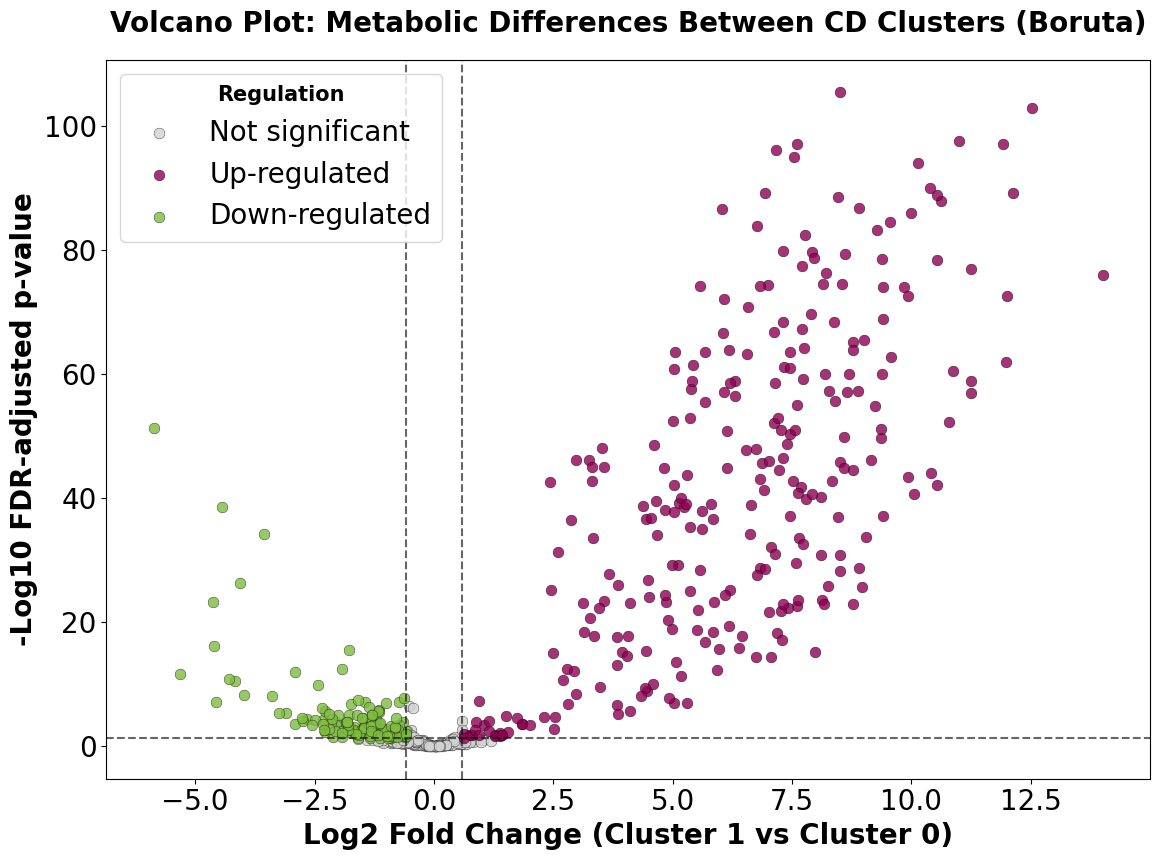


Results saved to:
- boruta_data/CD_differential_metabolites.tsv (all results)
- boruta_data/CD_up_regulated_metabolites.tsv (up in Cluster 1)
- boruta_data/CD_down_regulated_metabolites.tsv (down in Cluster 1)
- boruta_data/CD_differential_metabolites_volcano.png (volcano plot)

Generating heatmap of top differential metabolites...


<Figure size 1600x1200 with 0 Axes>

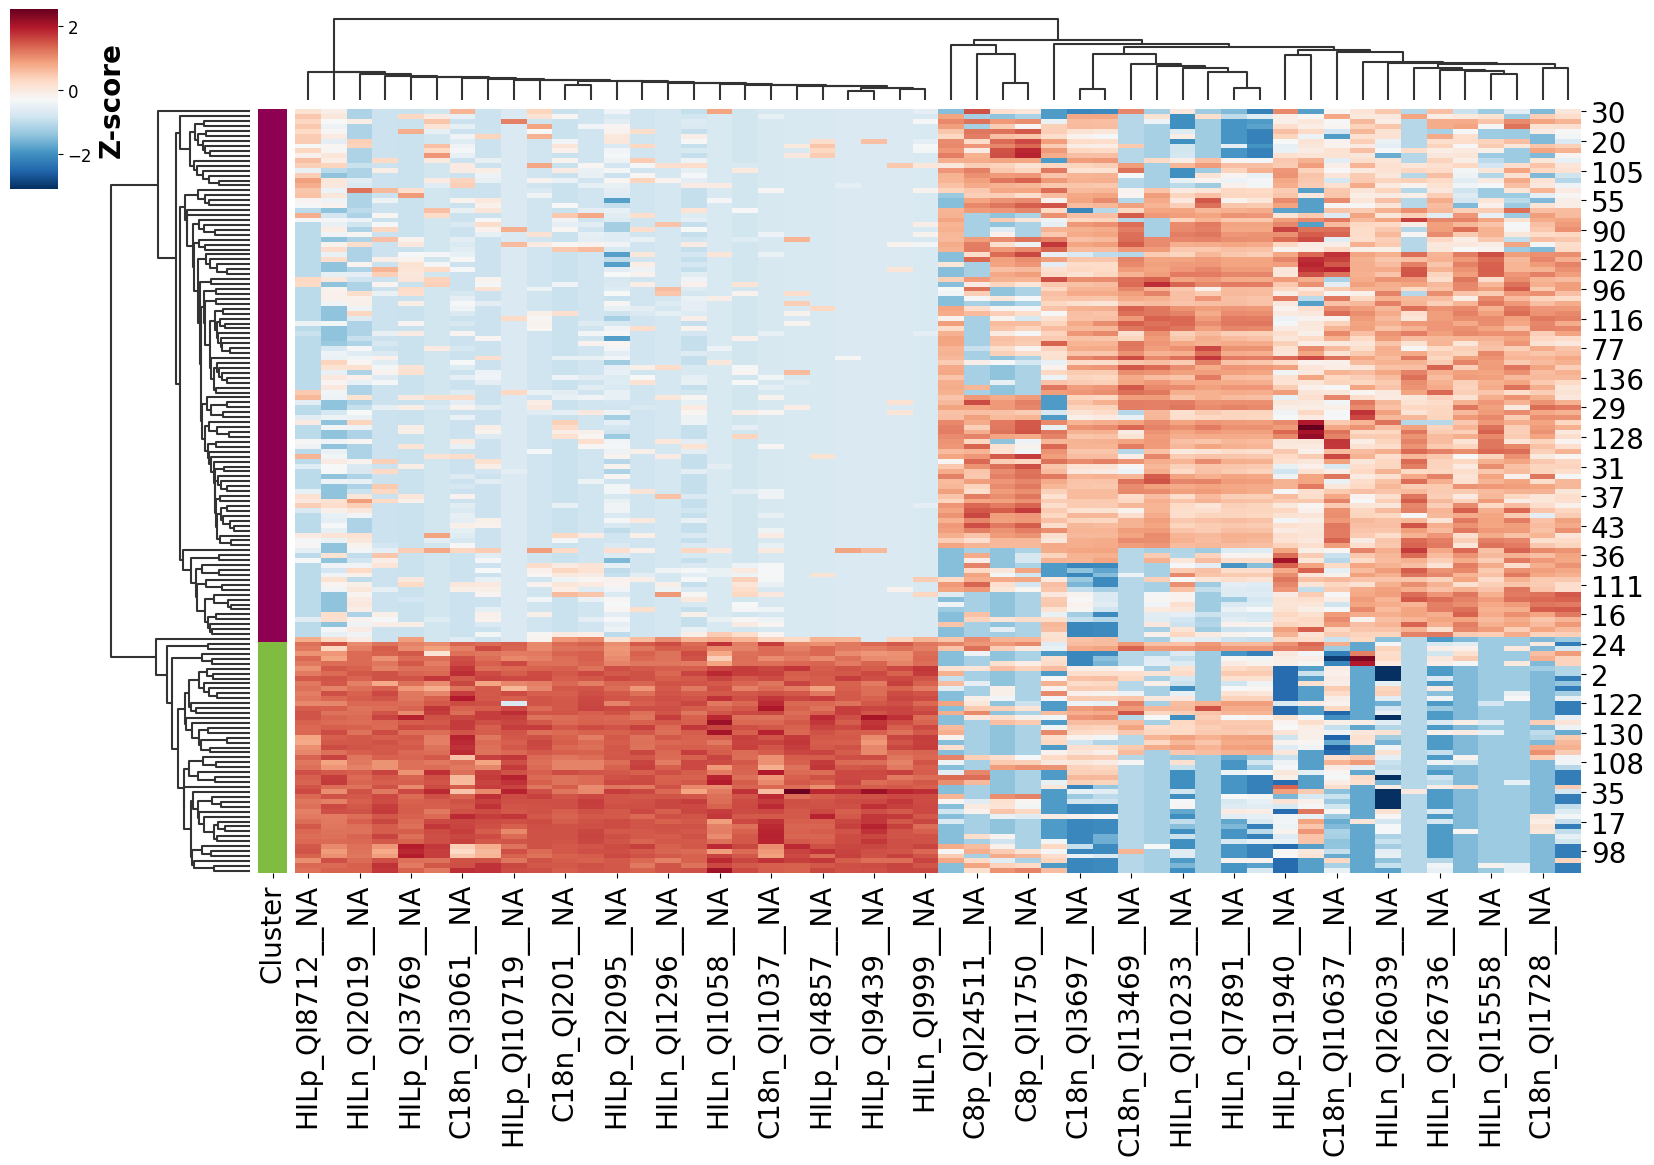


Differential Abundance Analysis Between UC Clusters (Boruta)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)



Differentially abundant metabolites (|FC| > 1.5, FDR < 0.05):
Up-regulated in Cluster 1: 69
Down-regulated in Cluster 1: 249
Not significant: 295


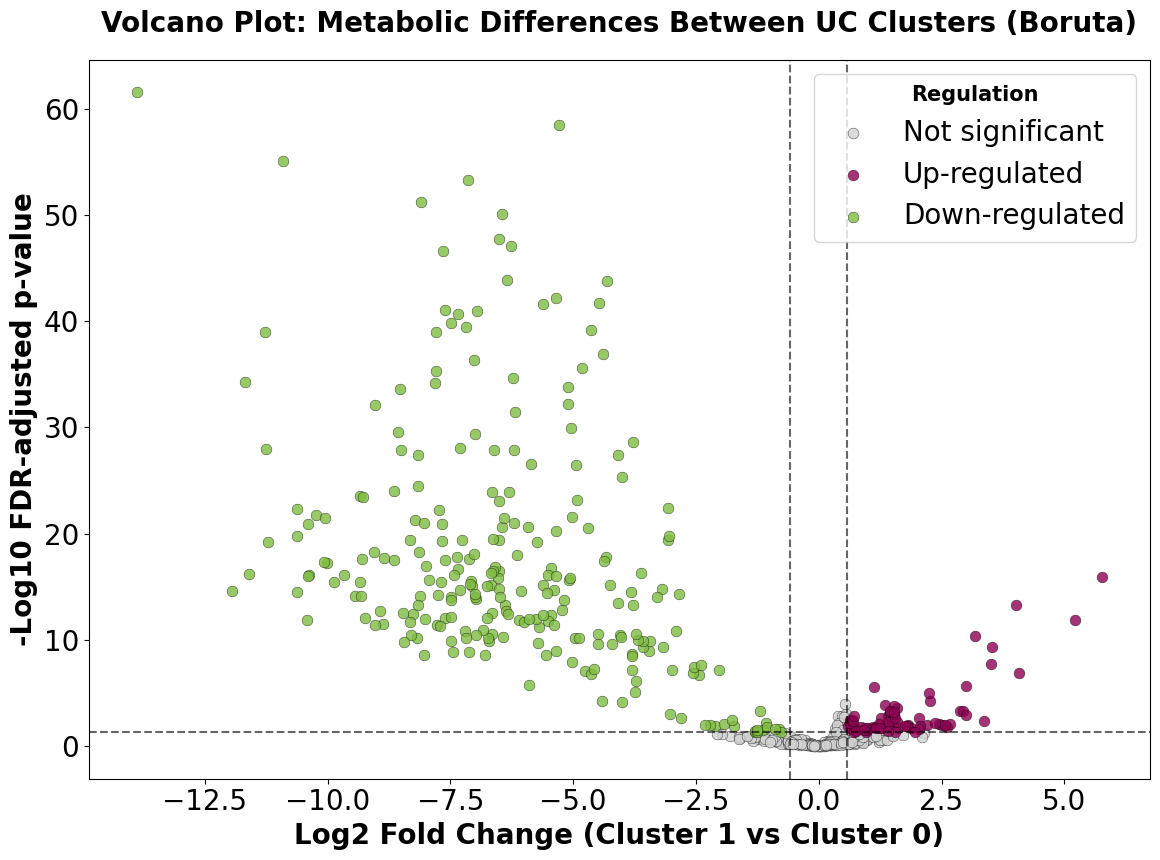


Results saved to:
- boruta_data/UC_differential_metabolites.tsv (all results)
- boruta_data/UC_up_regulated_metabolites.tsv (up in Cluster 1)
- boruta_data/UC_down_regulated_metabolites.tsv (down in Cluster 1)
- boruta_data/UC_differential_metabolites_volcano.png (volcano plot)

Generating heatmap of top differential metabolites...


<Figure size 1600x1200 with 0 Axes>

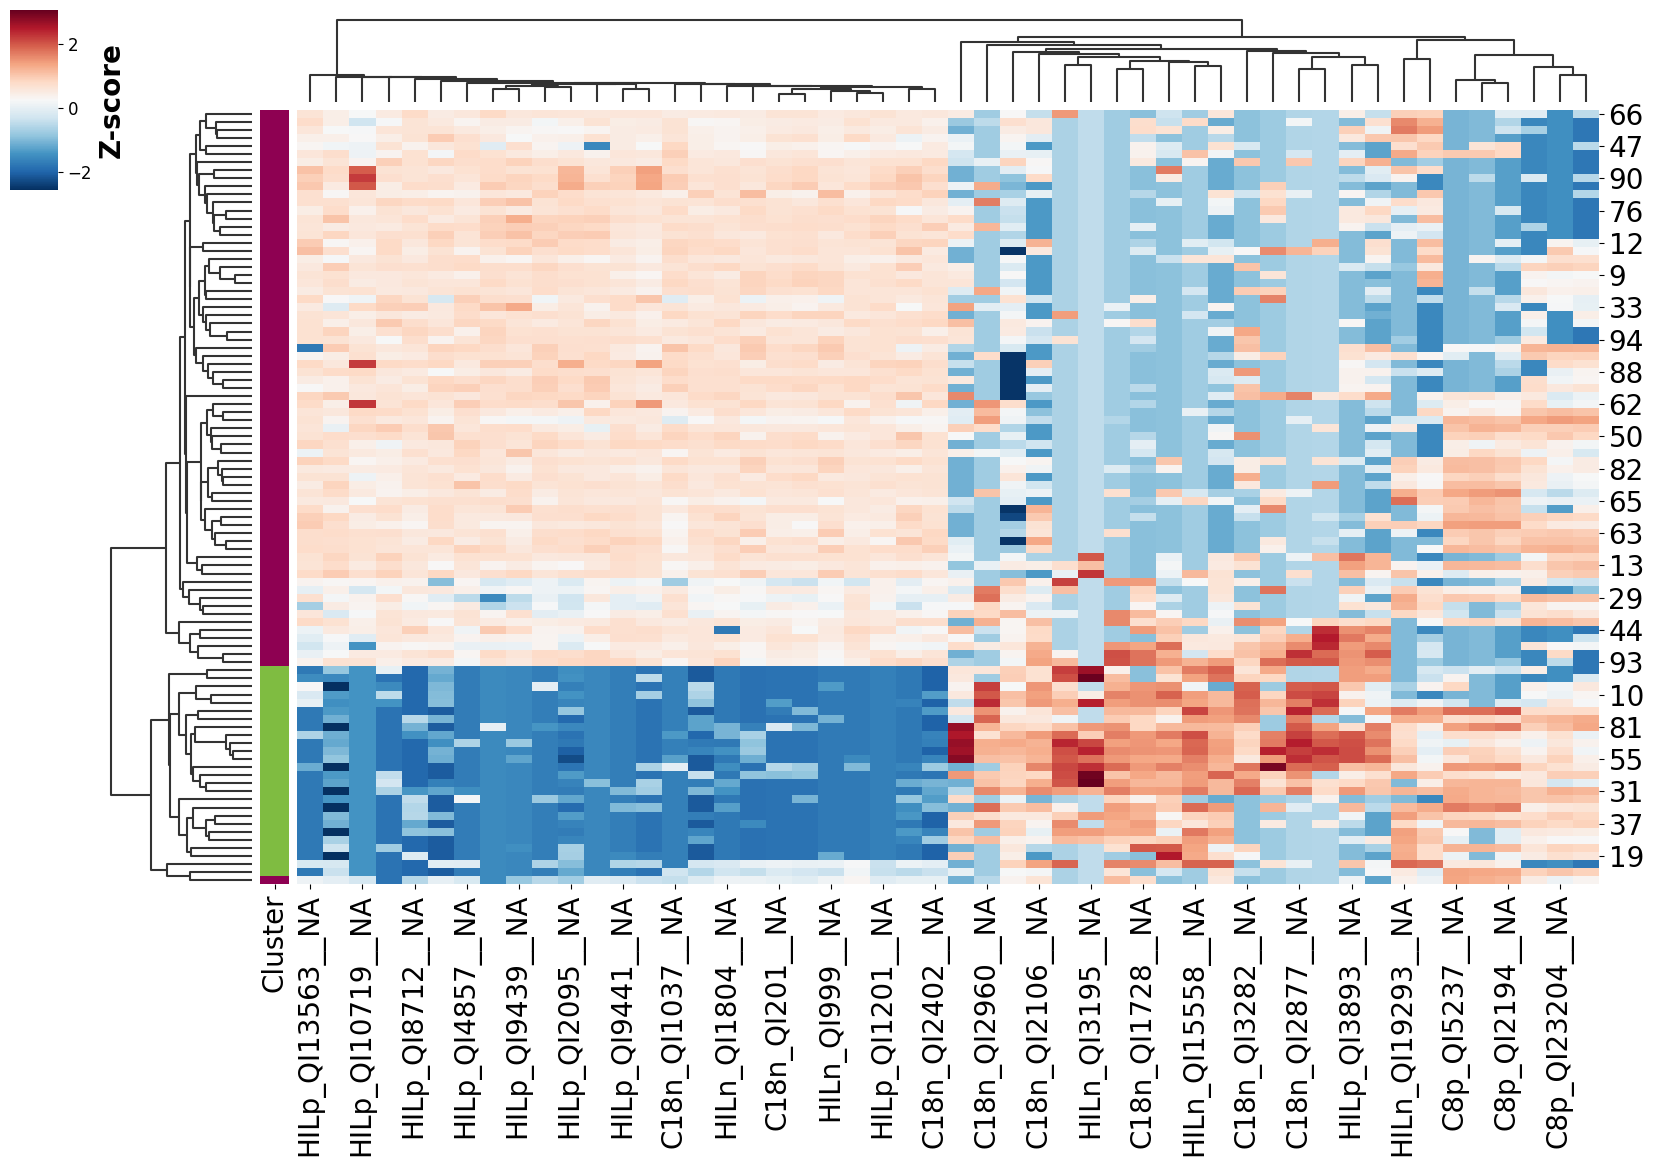


Comparison of CD and UC Differential Metabolites (Boruta)
CD significant metabolites: 403
UC significant metabolites: 318
Overlapping significant metabolites: 274
Percentage of CD metabolites also significant in UC: 68.0%
Percentage of UC metabolites also significant in CD: 86.2%

Directional consistency in overlapping metabolites:
Same direction in both diseases: 5 (1.8%)
Opposite direction between diseases: 269 (98.2%)


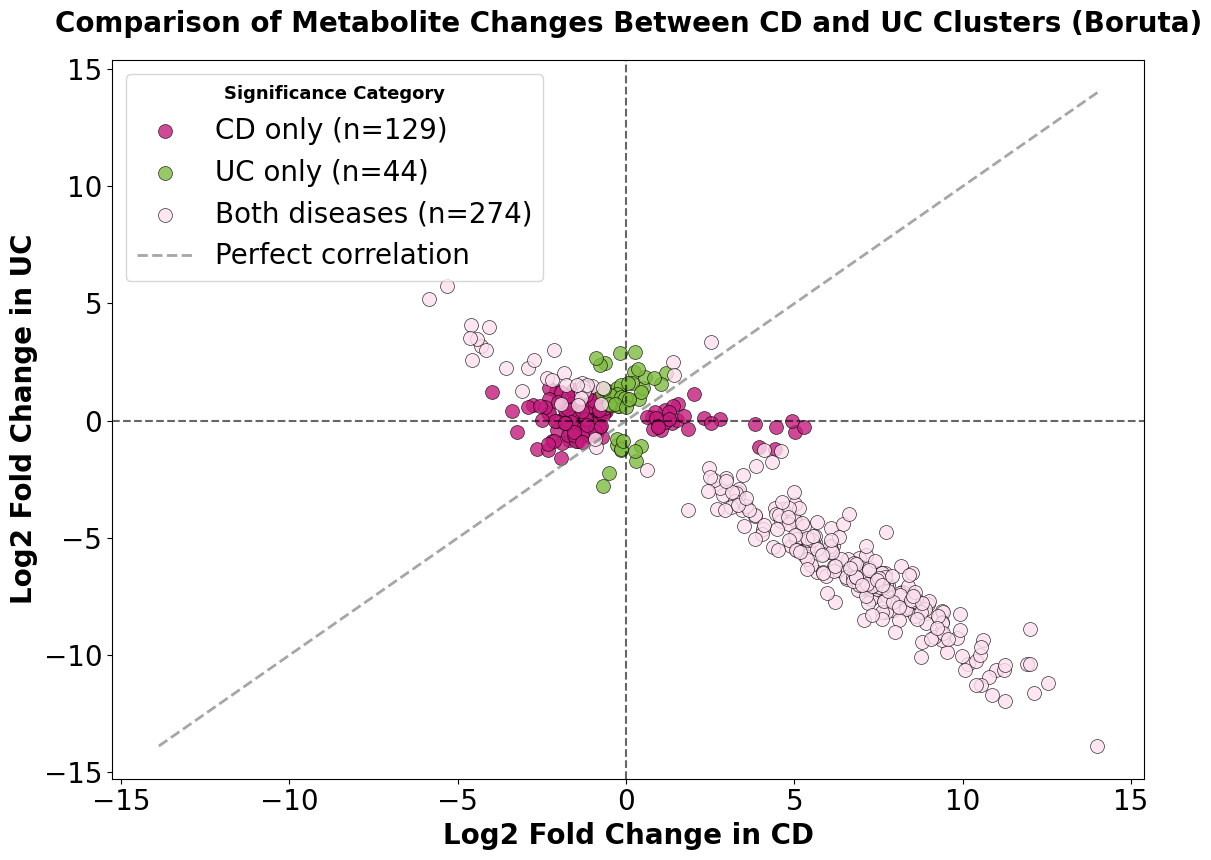

Plot includes 129 CD-only, 44 UC-only, and 274 shared significant metabolites
Comparison data saved to: boruta_data/CD_UC_differential_metabolite_comparison.tsv

Detailed Analysis of Shared Metabolites (Significant in Both Diseases) - Boruta


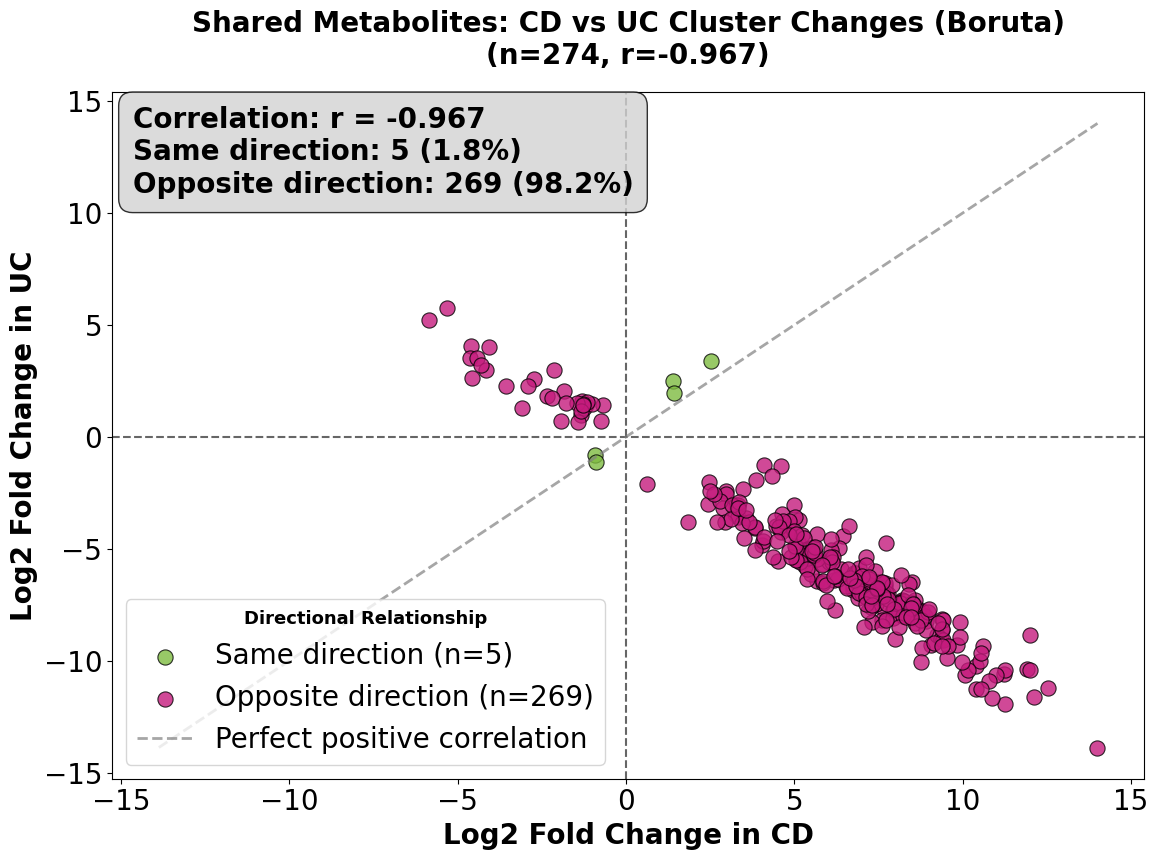

Correlation between CD and UC fold changes: r = -0.967
Metabolites with same direction: 5/274 (1.8%)
Metabolites with opposite direction: 269/274 (98.2%)
Shared metabolites comparison data saved to: boruta_data/CD_UC_shared_metabolites_comparison.tsv


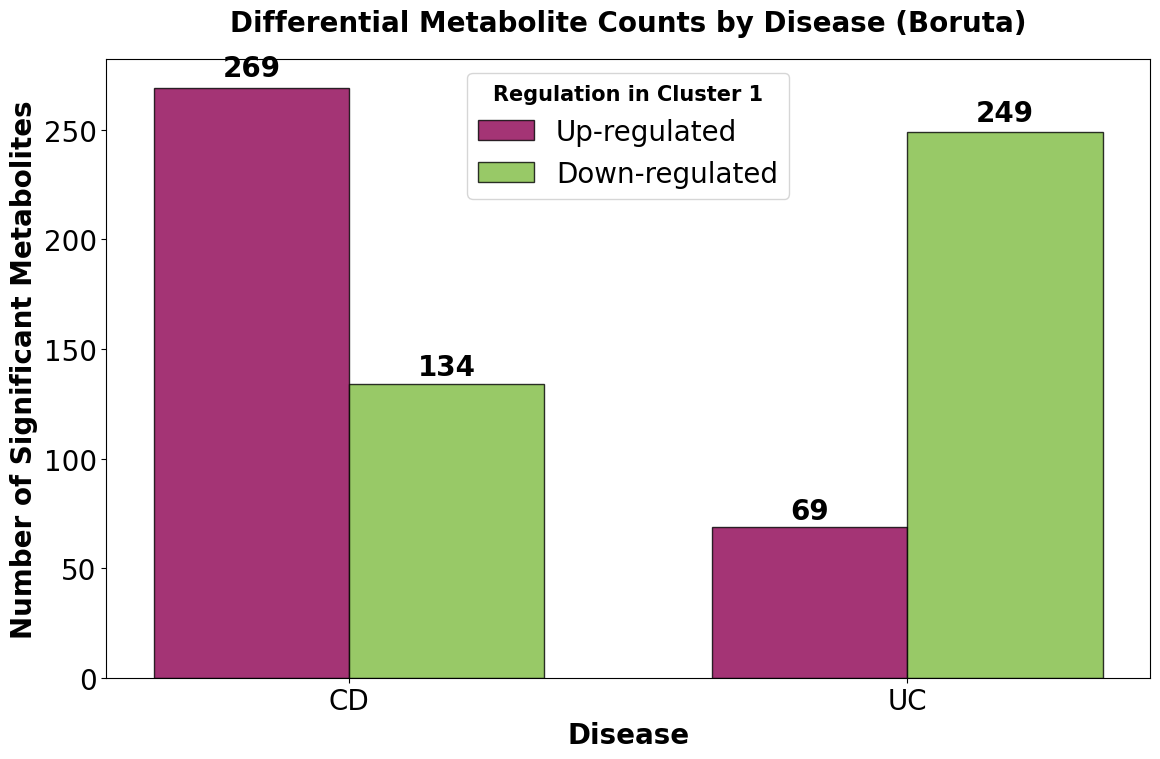


Disease-Specific Metabolites Visualization (Excluding Shared) - Boruta
CD-specific significant metabolites: 129
UC-specific significant metabolites: 44


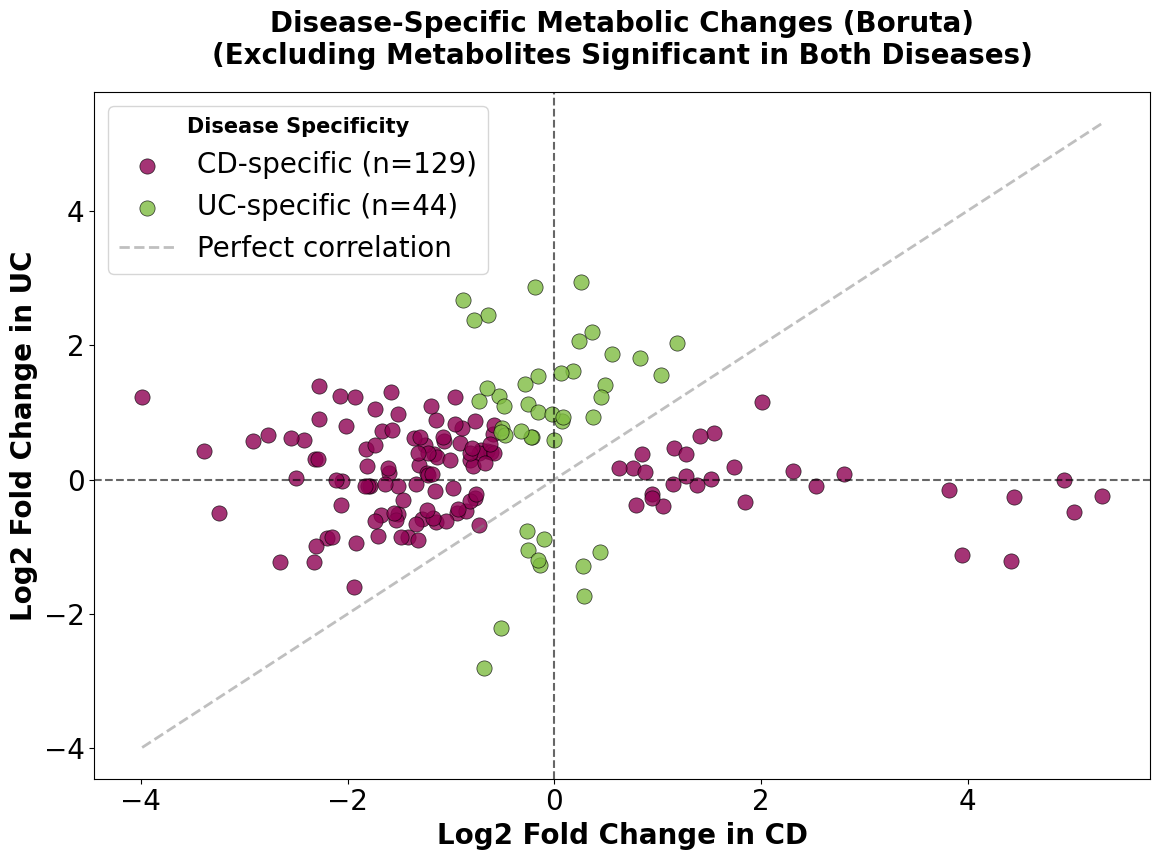

Disease-specific comparison data saved to: boruta_data/CD_UC_disease_specific_comparison.tsv

Disease Specificity Summary:
Disease  Specific_Metabolites  Total_Significant  Percentage_Specific
     CD                   129                403                 32.0
     UC                    44                318                 13.8
Specificity summary saved to: boruta_data/disease_specificity_summary.tsv


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap
import matplotlib as mpl

colors = ['#8e0152','#c51b7d','#de77ae','#f1b6da','#fde0ef','#e6f5d0','#b8e186','#7fbc41','#4d9221','#276419']

# Set global font sizes
plt.rcParams.update({
    'font.size': 20,
    'axes.titlesize': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'legend.fontsize': 20,
    'figure.titlesize': 20
})

print("Loading data...")
cd_clustered_file = 'processing_data/CD_kmeans_2_clustered_data.tsv'
uc_clustered_file = 'processing_data/UC_kmeans_2_clustered_data.tsv'

cd_df = pd.read_csv(cd_clustered_file, sep='\t')
uc_df = pd.read_csv(uc_clustered_file, sep='\t')

print(f"CD data shape: {cd_df.shape}")
print(f"UC data shape: {uc_df.shape}")

# feature columns separately for each disease
cd_feature_cols = [col for col in cd_df.columns if col.startswith(('C18n_', 'C8p_', 'HILn_', 'HILp_'))]
uc_feature_cols = [col for col in uc_df.columns if col.startswith(('C18n_', 'C8p_', 'HILn_', 'HILp_'))]

print(f"Number of CD metabolic features: {len(cd_feature_cols)}")
print(f"Number of UC metabolic features: {len(uc_feature_cols)}")

# Find common features between datasets
common_features = set(cd_feature_cols).intersection(set(uc_feature_cols))
print(f"Number of common metabolic features: {len(common_features)}")

# Extract cluster labels
cluster_labels_cd = cd_df['KMeans_Cluster'].values
cluster_labels_uc = uc_df['KMeans_Cluster'].values

# Function to perform differential abundance analysis
def differential_abundance_analysis(df, cluster_labels, feature_cols, disease_name):
    print("\n" + "="*50)
    print(f"Differential Abundance Analysis Between {disease_name} Clusters (Boruta)")
    print("="*50)
    
    # 1. Calculate statistics for each metabolite
    results = []
    for feature in feature_cols:
        # Get values for each cluster
        values_cluster0 = df.loc[cluster_labels == 0, feature]
        values_cluster1 = df.loc[cluster_labels == 1, feature]
        
        # Calculate fold change (data is already log-transformed)
        mean_cluster0 = values_cluster0.mean()
        mean_cluster1 = values_cluster1.mean()
        log2_fold_change = mean_cluster1 - mean_cluster0
        
        # Perform t-test
        t_stat, p_val = stats.ttest_ind(values_cluster1, values_cluster0, equal_var=False)
        
        results.append({
            'feature': feature,
            'mean_cluster0': mean_cluster0,
            'mean_cluster1': mean_cluster1,
            'log2_fold_change': log2_fold_change,
            't_statistic': t_stat,
            'p_value': p_val
        })
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    # 2. Apply FDR correction
    results_df['fdr_adjusted_p'] = multipletests(results_df['p_value'], method='fdr_bh')[1]
    
    # 3. Applying thresholds to identify significant metabolites
    # Using |log2_fold_change| > log2(1.5) and FDR < 0.05
    log2_fc_threshold = np.log2(1.5)
    fdr_threshold = 0.05
    
    results_df['significant'] = (abs(results_df['log2_fold_change']) > log2_fc_threshold) & (results_df['fdr_adjusted_p'] < fdr_threshold)
    results_df['regulation'] = 'NS'  # Not significant
    results_df.loc[(results_df['significant']) & (results_df['log2_fold_change'] > 0), 'regulation'] = 'Up'
    results_df.loc[(results_df['significant']) & (results_df['log2_fold_change'] < 0), 'regulation'] = 'Down'
    
    # Count significant metabolites
    sig_counts = results_df['regulation'].value_counts()
    print(f"\nDifferentially abundant metabolites (|FC| > 1.5, FDR < 0.05):")
    print(f"Up-regulated in Cluster 1: {sig_counts.get('Up', 0)}")
    print(f"Down-regulated in Cluster 1: {sig_counts.get('Down', 0)}")
    print(f"Not significant: {sig_counts.get('NS', 0)}")
    
    # 4. Volcano plot with custom styling
    plt.figure(figsize=(12, 9))
    
    # Create separate scatter plots for each regulation type with custom colors
    for reg_type, color in [('NS', 'lightgray'), ('Up', colors[0]), ('Down', colors[7])]:
        mask = results_df['regulation'] == reg_type
        if mask.any():
            plt.scatter(
                results_df.loc[mask, 'log2_fold_change'],
                -np.log10(results_df.loc[mask, 'fdr_adjusted_p']),
                c=color,
                label=f'{reg_type}-regulated' if reg_type != 'NS' else 'Not significant',
                alpha=0.8,
                s=60,
                edgecolors='black',
                linewidth=0.3
            )
    plt.axhline(-np.log10(fdr_threshold), color='black', linestyle='--', alpha=0.6, linewidth=1.5)
    plt.axvline(log2_fc_threshold, color='black', linestyle='--', alpha=0.6, linewidth=1.5)
    plt.axvline(-log2_fc_threshold, color='black', linestyle='--', alpha=0.6, linewidth=1.5)
    plt.title(f'Volcano Plot: Metabolic Differences Between {disease_name} Clusters (Boruta)', 
              fontsize=20, fontweight='semibold', pad=20)
    plt.xlabel('Log2 Fold Change (Cluster 1 vs Cluster 0)', 
               fontsize=20, fontweight='semibold')
    plt.ylabel('-Log10 FDR-adjusted p-value', 
               fontsize=20, fontweight='semibold')
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    legend = plt.legend(fontsize=20, title_fontsize=20)
    legend.set_title("Regulation", prop={'size': 15, 'weight': 'semibold'})
    plt.grid(False)
    plt.tight_layout()
    plt.show()

    results_df.to_csv(f'boruta_data/{disease_name}_differential_metabolites.tsv', sep='\t', index=False)
    
    # 6. Export lists of significant metabolites
    up_regulated = results_df[results_df['regulation'] == 'Up'].sort_values('log2_fold_change', ascending=False)
    down_regulated = results_df[results_df['regulation'] == 'Down'].sort_values('log2_fold_change')
    
    up_regulated.to_csv(f'boruta_data/{disease_name}_up_regulated_metabolites.tsv', sep='\t', index=False)
    down_regulated.to_csv(f'boruta_data/{disease_name}_down_regulated_metabolites.tsv', sep='\t', index=False)
    
    print(f"\nResults saved to:")
    print(f"- boruta_data/{disease_name}_differential_metabolites.tsv (all results)")
    print(f"- boruta_data/{disease_name}_up_regulated_metabolites.tsv (up in Cluster 1)")
    print(f"- boruta_data/{disease_name}_down_regulated_metabolites.tsv (down in Cluster 1)")
    print(f"- boruta_data/{disease_name}_differential_metabolites_volcano.png (volcano plot)")
    
    # 7. Create a heatmap of top differentially abundant metabolites
    print("\nGenerating heatmap of top differential metabolites...")
    top_up = list(up_regulated.head(25)['feature'])
    top_down = list(down_regulated.head(25)['feature'])
    top_diff_features = top_up + top_down
    
    if top_diff_features:  # Only create heatmap if there are significant features
        heatmap_data = df[top_diff_features].copy()
        # Z-score normalize the data for better visualization
        heatmap_data_scaled = StandardScaler().fit_transform(heatmap_data)
        heatmap_df = pd.DataFrame(heatmap_data_scaled, columns=top_diff_features)
        heatmap_df['Cluster'] = cluster_labels
        row_colors = pd.DataFrame({'Cluster': heatmap_df['Cluster']}).replace({0: colors[0], 1: colors[7]})
        plt.figure(figsize=(16, 12))
        g = sns.clustermap(
            heatmap_df.drop('Cluster', axis=1),
            row_colors=row_colors,
            cmap='RdBu_r',
            figsize=(16, 12),
            dendrogram_ratio=0.1,
            colors_ratio=0.02,
            cbar_kws={'label': 'Z-score'},
            tree_kws={'linewidths': 1.5}
        )
        cbar = g.ax_cbar
        cbar.set_position([-0.04, 0.83, 0.03, 0.15])  # [left, bottom, width, height]
        cbar.set_ylabel('Z-score', fontsize=20, fontweight='semibold')
        cbar.tick_params(labelsize=12)
        plt.show()
    else:
        print("No significant differential metabolites found for heatmap.")
    
    return results_df

# Run differential abundance analysis for CD with CD-specific features
results_df = differential_abundance_analysis(cd_df, cluster_labels_cd, cd_feature_cols, 'CD')

# Run differential abundance analysis for UC with UC-specific features
results_uc_df = differential_abundance_analysis(uc_df, cluster_labels_uc, uc_feature_cols, 'UC')

# Compare CD and UC differential metabolites - use only common features
print("\n" + "="*50)
print("Comparison of CD and UC Differential Metabolites (Boruta)")
print("="*50)

# Find common features that are significant in both diseases
cd_sig = set(results_df[results_df['significant']]['feature'])
uc_sig = set(results_uc_df[results_uc_df['significant']]['feature'])

# Find overlap only among features present in both datasets
overlap_sig = cd_sig.intersection(uc_sig)

print(f"CD significant metabolites: {len(cd_sig)}")
print(f"UC significant metabolites: {len(uc_sig)}")
print(f"Overlapping significant metabolites: {len(overlap_sig)}")
if len(cd_sig) > 0:
    print(f"Percentage of CD metabolites also significant in UC: {len(overlap_sig)/len(cd_sig)*100:.1f}%")
if len(uc_sig) > 0:
    print(f"Percentage of UC metabolites also significant in CD: {len(overlap_sig)/len(uc_sig)*100:.1f}%")

# Check directional consistency
if len(overlap_sig) > 0:
    consistent_direction = 0
    inconsistent_direction = 0

    for feature in overlap_sig:
        cd_direction = results_df.loc[results_df['feature'] == feature, 'log2_fold_change'].values[0]
        uc_direction = results_uc_df.loc[results_uc_df['feature'] == feature, 'log2_fold_change'].values[0]
        
        if (cd_direction > 0 and uc_direction > 0) or (cd_direction < 0 and uc_direction < 0):
            consistent_direction += 1
        else:
            inconsistent_direction += 1

    print(f"\nDirectional consistency in overlapping metabolites:")
    print(f"Same direction in both diseases: {consistent_direction} ({consistent_direction/len(overlap_sig)*100:.1f}%)")
    print(f"Opposite direction between diseases: {inconsistent_direction} ({inconsistent_direction/len(overlap_sig)*100:.1f}%)")

    # Create a comprehensive scatter plot comparing fold changes between diseases
    # Include all common features, not just those significant in both
    overlap_features = list(overlap_sig)
    
    # Get all common features between datasets that are significant in at least one disease
    cd_only_sig = cd_sig - uc_sig  # Significant in CD but not UC
    uc_only_sig = uc_sig - cd_sig  # Significant in UC but not CD
    all_sig_features = cd_sig.union(uc_sig)
    
    # Filter to only include features present in both datasets
    all_sig_common = all_sig_features.intersection(common_features)
    cd_only_common = cd_only_sig.intersection(common_features)
    uc_only_common = uc_only_sig.intersection(common_features)
    overlap_common = overlap_sig.intersection(common_features)
    
    if len(all_sig_common) > 0:
        # Get fold change data for all significant common features
        cd_fc_all = results_df.loc[results_df['feature'].isin(all_sig_common), ['feature', 'log2_fold_change']].set_index('feature')
        uc_fc_all = results_uc_df.loc[results_uc_df['feature'].isin(all_sig_common), ['feature', 'log2_fold_change']].set_index('feature')
        
        comparison_df_all = pd.merge(cd_fc_all, uc_fc_all, left_index=True, right_index=True, suffixes=('_CD', '_UC'))

        plt.figure(figsize=(12, 9))
        cd_only_color = colors[1]  # Dark pink for CD-only significant
        uc_only_color = colors[7]  # Green for UC-only significant  
        both_color = colors[4]     # Light pink for significant in both
        
        # Plot each category separately
        for feature_set, color, label in [
            (cd_only_common, cd_only_color, f'CD only (n={len(cd_only_common)})'),
            (uc_only_common, uc_only_color, f'UC only (n={len(uc_only_common)})'),
            (overlap_common, both_color, f'Both diseases (n={len(overlap_common)})')
        ]:
            if len(feature_set) > 0:
                subset_df = comparison_df_all.loc[list(feature_set)]
                plt.scatter(subset_df['log2_fold_change_CD'], subset_df['log2_fold_change_UC'], 
                           alpha=0.8, s=100, color=color, edgecolors='black', linewidth=0.5,
                           label=label)
        plt.axhline(0, color='black', linestyle='--', alpha=0.6, linewidth=1.5)
        plt.axvline(0, color='black', linestyle='--', alpha=0.6, linewidth=1.5)
        min_val = min(comparison_df_all['log2_fold_change_CD'].min(), comparison_df_all['log2_fold_change_UC'].min())
        max_val = max(comparison_df_all['log2_fold_change_CD'].max(), comparison_df_all['log2_fold_change_UC'].max())
        plt.plot([min_val, max_val], [min_val, max_val], color='gray', linestyle='--', alpha=0.7, linewidth=2, label='Perfect correlation')
        plt.xlabel('Log2 Fold Change in CD', fontsize=20, fontweight='semibold')
        plt.ylabel('Log2 Fold Change in UC', fontsize=20, fontweight='semibold')
        plt.title('Comparison of Metabolite Changes Between CD and UC Clusters (Boruta)', 
                  fontsize=20, fontweight='semibold', pad=20)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        legend = plt.legend(fontsize=20, title_fontsize=20, loc='best')
        legend.set_title("Significance Category", prop={'size': 13, 'weight': 'semibold'})
        plt.grid(False)
        plt.tight_layout()
        plt.show()

        print(f"Plot includes {len(cd_only_common)} CD-only, {len(uc_only_common)} UC-only, and {len(overlap_common)} shared significant metabolites")

        comparison_df_all.to_csv('boruta_data/CD_UC_differential_metabolite_comparison.tsv', sep='\t')
        print(f"Comparison data saved to: boruta_data/CD_UC_differential_metabolite_comparison.tsv")
    else:
        print("\nNo common significant metabolites found between CD and UC for comparison plot.")

    # Create a second comparison plot showing ONLY metabolites significant in both diseases
    print("\n" + "="*50)
    print("Detailed Analysis of Shared Metabolites (Significant in Both Diseases) - Boruta")
    print("="*50)
    
    if len(overlap_common) > 0:
        # Get fold change data for only the shared significant metabolites
        cd_fc_shared = results_df.loc[results_df['feature'].isin(overlap_common), ['feature', 'log2_fold_change']].set_index('feature')
        uc_fc_shared = results_uc_df.loc[results_uc_df['feature'].isin(overlap_common), ['feature', 'log2_fold_change']].set_index('feature')
        
        comparison_shared_df = pd.merge(cd_fc_shared, uc_fc_shared, left_index=True, right_index=True, suffixes=('_CD', '_UC'))
        plt.figure(figsize=(12, 9))
        shared_fc_cd = comparison_shared_df['log2_fold_change_CD'].values
        shared_fc_uc = comparison_shared_df['log2_fold_change_UC'].values
        same_direction = ((shared_fc_cd > 0) & (shared_fc_uc > 0)) | ((shared_fc_cd < 0) & (shared_fc_uc < 0))
        opposite_direction = ((shared_fc_cd > 0) & (shared_fc_uc < 0)) | ((shared_fc_cd < 0) & (shared_fc_uc > 0))
        if np.any(same_direction):
            plt.scatter(
                shared_fc_cd[same_direction], 
                shared_fc_uc[same_direction],
                alpha=0.8, s=120, color=colors[7], edgecolors='black', linewidth=0.8,
                label=f'Same direction (n={np.sum(same_direction)})'
            )
        if np.any(opposite_direction):
            plt.scatter(
                shared_fc_cd[opposite_direction], 
                shared_fc_uc[opposite_direction],
                alpha=0.8, s=120, color=colors[1], edgecolors='black', linewidth=0.8,
                label=f'Opposite direction (n={np.sum(opposite_direction)})'
            )
        plt.axhline(0, color='black', linestyle='--', alpha=0.6, linewidth=1.5)
        plt.axvline(0, color='black', linestyle='--', alpha=0.6, linewidth=1.5)
        min_val = min(shared_fc_cd.min(), shared_fc_uc.min())
        max_val = max(shared_fc_cd.max(), shared_fc_uc.max())
        plt.plot([min_val, max_val], [min_val, max_val], color='gray', linestyle='--', alpha=0.7, linewidth=2, label='Perfect positive correlation')
        correlation = np.corrcoef(shared_fc_cd, shared_fc_uc)[0, 1]
        plt.xlabel('Log2 Fold Change in CD', fontsize=20, fontweight='semibold')
        plt.ylabel('Log2 Fold Change in UC', fontsize=20, fontweight='semibold')
        plt.title(f'Shared Metabolites: CD vs UC Cluster Changes (Boruta)\n(n={len(overlap_common)}, r={correlation:.3f})', 
                  fontsize=20, fontweight='semibold', pad=20)
        stats_text = f"Correlation: r = {correlation:.3f}\n"
        stats_text += f"Same direction: {np.sum(same_direction)} ({np.sum(same_direction)/len(overlap_common)*100:.1f}%)\n"
        stats_text += f"Opposite direction: {np.sum(opposite_direction)} ({np.sum(opposite_direction)/len(overlap_common)*100:.1f}%)"
        plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes, 
                bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8),
                verticalalignment='top', fontsize=20, fontweight='semibold')
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        legend = plt.legend(fontsize=20, title_fontsize=20, loc='lower left')
        legend.set_title("Directional Relationship", prop={'size': 13, 'weight': 'semibold'})
        plt.grid(False)
        plt.tight_layout()
        plt.show()

        print(f"Correlation between CD and UC fold changes: r = {correlation:.3f}")
        print(f"Metabolites with same direction: {np.sum(same_direction)}/{len(overlap_common)} ({np.sum(same_direction)/len(overlap_common)*100:.1f}%)")
        print(f"Metabolites with opposite direction: {np.sum(opposite_direction)}/{len(overlap_common)} ({np.sum(opposite_direction)/len(overlap_common)*100:.1f}%)")

        # Save the shared metabolites comparison data
        comparison_shared_df['Direction_Consistency'] = 'Same'
        comparison_shared_df.loc[opposite_direction, 'Direction_Consistency'] = 'Opposite'
        comparison_shared_df['Correlation'] = correlation
        
        comparison_shared_df.to_csv('boruta_data/CD_UC_shared_metabolites_comparison.tsv', sep='\t')
        print(f"Shared metabolites comparison data saved to: boruta_data/CD_UC_shared_metabolites_comparison.tsv")
    else:
        print("No metabolites significant in both diseases found for detailed analysis.")


# Create a summary comparison plot
plt.figure(figsize=(12, 8))

# Summary data
diseases = ['CD', 'UC']
up_counts = [
    results_df[results_df['regulation'] == 'Up'].shape[0],
    results_uc_df[results_uc_df['regulation'] == 'Up'].shape[0]
]
down_counts = [
    results_df[results_df['regulation'] == 'Down'].shape[0],
    results_uc_df[results_uc_df['regulation'] == 'Down'].shape[0]
]

x = np.arange(len(diseases))
width = 0.35

bars1 = plt.bar(x - width/2, up_counts, width, label='Up-regulated', 
                color=colors[0], alpha=0.8, edgecolor='black', linewidth=1)
bars2 = plt.bar(x + width/2, down_counts, width, label='Down-regulated', 
                color=colors[7], alpha=0.8, edgecolor='black', linewidth=1)
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{int(height)}', ha='center', va='bottom', fontsize=20, fontweight='semibold')
plt.xlabel('Disease', fontsize=20, fontweight='semibold')
plt.ylabel('Number of Significant Metabolites', fontsize=20, fontweight='semibold')
plt.title('Differential Metabolite Counts by Disease (Boruta)', fontsize=20, fontweight='semibold', pad=20)
plt.xticks(x, diseases, fontsize=20)
plt.yticks(fontsize=20)
legend = plt.legend(fontsize=20, title_fontsize=20)
legend.set_title("Regulation in Cluster 1", prop={'size': 15, 'weight': 'semibold'})
plt.grid(False)
plt.tight_layout()
plt.show()

# A visualization showing only disease-specific metabolites (excluding shared ones)
print("\n" + "="*50)
print("Disease-Specific Metabolites Visualization (Excluding Shared) - Boruta")
print("="*50)

# Disease-specific significant features (excluding those significant in both)
cd_only_sig = cd_sig - uc_sig  # Significant in CD but not UC
uc_only_sig = uc_sig - cd_sig  # Significant in UC but not CD

# Filter to only include features present in both datasets
cd_only_common = cd_only_sig.intersection(common_features)
uc_only_common = uc_only_sig.intersection(common_features)

print(f"CD-specific significant metabolites: {len(cd_only_common)}")
print(f"UC-specific significant metabolites: {len(uc_only_common)}")

if len(cd_only_common) > 0 or len(uc_only_common) > 0:
    # Combine disease-specific features for plotting
    disease_specific_features = list(cd_only_common.union(uc_only_common))
    
    # Get fold change data for disease-specific features
    cd_fc_specific = results_df.loc[results_df['feature'].isin(disease_specific_features), ['feature', 'log2_fold_change']].set_index('feature')
    uc_fc_specific = results_uc_df.loc[results_uc_df['feature'].isin(disease_specific_features), ['feature', 'log2_fold_change']].set_index('feature')
    
    comparison_specific_df = pd.merge(cd_fc_specific, uc_fc_specific, left_index=True, right_index=True, suffixes=('_CD', '_UC'))

    plt.figure(figsize=(12, 9))
    
    # Define colors for disease-specific categories
    cd_only_color = colors[0]  # Dark pink for CD-only significant
    uc_only_color = colors[7]  # Dark green for UC-only significant
    
    # Plot each category separately
    for feature_set, color, label in [
        (cd_only_common, cd_only_color, f'CD-specific (n={len(cd_only_common)})'),
        (uc_only_common, uc_only_color, f'UC-specific (n={len(uc_only_common)})')
    ]:
        if len(feature_set) > 0:
            subset_df = comparison_specific_df.loc[list(feature_set)]
            plt.scatter(subset_df['log2_fold_change_CD'], subset_df['log2_fold_change_UC'], 
                       alpha=0.8, s=120, color=color, edgecolors='black', linewidth=0.5,
                       label=label)
    plt.axhline(0, color='black', linestyle='--', alpha=0.6, linewidth=1.5)
    plt.axvline(0, color='black', linestyle='--', alpha=0.6, linewidth=1.5)
    min_val = min(comparison_specific_df['log2_fold_change_CD'].min(), comparison_specific_df['log2_fold_change_UC'].min())
    max_val = max(comparison_specific_df['log2_fold_change_CD'].max(), comparison_specific_df['log2_fold_change_UC'].max())
    plt.plot([min_val, max_val], [min_val, max_val], color='gray', linestyle='--', alpha=0.5, linewidth=2, label='Perfect correlation')
    plt.xlabel('Log2 Fold Change in CD', fontsize=20, fontweight='semibold')
    plt.ylabel('Log2 Fold Change in UC', fontsize=20, fontweight='semibold')
    plt.title('Disease-Specific Metabolic Changes (Boruta)\n(Excluding Metabolites Significant in Both Diseases)', 
              fontsize=20, fontweight='semibold', pad=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    legend = plt.legend(fontsize=20, title_fontsize=20, loc='best')
    legend.set_title("Disease Specificity", prop={'size': 15, 'weight': 'semibold'})
    plt.grid(False)
    plt.tight_layout()
    plt.show()

    # Save the disease-specific comparison data
    comparison_specific_df.to_csv('boruta_data/CD_UC_disease_specific_comparison.tsv', sep='\t')
    print(f"Disease-specific comparison data saved to: boruta_data/CD_UC_disease_specific_comparison.tsv")
    
    # Create a summary table for disease-specific metabolites
    specificity_summary = pd.DataFrame([
        {'Disease': 'CD', 'Specific_Metabolites': len(cd_only_common), 'Total_Significant': len(cd_sig)},
        {'Disease': 'UC', 'Specific_Metabolites': len(uc_only_common), 'Total_Significant': len(uc_sig)}
    ])
    specificity_summary['Percentage_Specific'] = (specificity_summary['Specific_Metabolites'] / specificity_summary['Total_Significant'] * 100).round(1)
    
    print(f"\nDisease Specificity Summary:")
    print(specificity_summary.to_string(index=False))
    
    specificity_summary.to_csv('boruta_data/disease_specificity_summary.tsv', sep='\t', index=False)
    print(f"Specificity summary saved to: boruta_data/disease_specificity_summary.tsv")
    
else:
    print("No disease-specific metabolites found for visualization.")